# Prediction of Corporate Default


# 1. Introduction

The prediction of corporate default is of great interest to investors and creditors. The objective of this exercise is to predict company default using a sample of 5000 companies with 30 (raw) features. <br>
I started with the basic Exploratory Data Analysis on the dataset, and then performed feature eigeneering through getting rid of highly-correlated features as well as choosing the most important fetures using the __feature_importance__ property of the Random Forest model. As here we are dealing with imbalanced dataset, I chose Random Forest Classifier to be my machine learning algorithm, which is relatively robust against the imbalanced data. To optimize the model, Grid Search cross-validation was applied and the finalized optimized model yields an approximate __roc-auc__ score of __0.885(7)__ and __f1__ score to be __0.43(3)__.

# 2. Exploratory Data Analysis

First, load the dataset. Note that in the original file, the missing values are represented by question marks (?), which I replaced with NaN while reading in the data. Then we can brief through the column names within the file with the first few lines

In [106]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# display all the columns without folding
pd.set_option('display.max_columns', 50)  

# Load dataset; Noticed '?' in the original file
data = pd.read_csv('Data Scientist Exercise04.csv', na_values='?') 
data.head()

net profit / total assets  working capital / total assets  \
0                   0.038680                        0.082838   
1                   0.040320                       -0.013260   
2                   0.043241                        0.197270   
3                   0.032621                       -0.072349   
4                   0.028320                       -0.097934   

   retained earnings / total assets   \
0                           0.000000   
1                           0.000000   
2                           0.082911   
3                          -0.371690   
4                           0.000000   

   book value of equity / total liabilities  sales / total assets  \
0                                   0.78767               0.98145   
1                                   0.64287               1.60620   
2                                   1.66460               1.01370   
3                                   0.00533               3.35600   
4                                   0.29318               1.13110   

   gross profit / short-term liabilities  \
0                               0.172390   
1                               0.072031   
2                               0.128480   
3                               0.043675   
4                               0.064054   

   (gross profit + depreciation) / sales  \
0                               0.107990   
1                               0.177900   
2                               0.061266   
3                               0.016499   
4                               0.086133   

   (total liabilities * 365) / (gross profit + depreciation)  \
0                                            1926.40           
1                                             777.52           
2                                            1325.30           
3                                            6556.80           
4                                            2897.00           

   gross profit / total assets  gross profit / sales  \
0                     0.049071              0.049999   
1                     0.040320              0.025103   
2                     0.043241              0.026489   
3                     0.042140              0.012557   
4                     0.030493              0.026958   

   profit on operating activities / total assets  \
0                                       0.071650   
1                                       0.000000   
2                                       0.040821   
3                                       0.075593   
4                                       0.081230   

   gross profit (in 3 years) / total assets  \
0                                  0.191350   
1                                  0.146480   
2                                  0.082911   
3                                       NaN   
4                                  0.129970   

   (equity - share capital) / total assets  \
0                                  0.43129   
1                                  0.38859   
2                                  0.60447   
3                                 -0.33420   
4                                  0.21602   

   profit on operating activities / financial expenses  \
0                                            3.13500     
1                                            0.00000     
2                                            0.25348     
3                                            1.78900     
4                                            1.58520     

   working capital / fixed assets  (gross profit + interest) / sales  \
0                        0.130970                           0.068077   
1                       -0.029239                           0.057236   
2                        0.423180                           0.026489   
3                       -0.673160                           0.021862   
4                       -0.157480                           0.065481   

   operating expenses / short-term liabilities  \
0    

Count the number of instances for each class. The positive (defaulted) class seems to take only 10% of all the samples, so this is an imbalanced dataset

In [107]:
data.defaulted.value_counts() 
# Classes are imbalanced

0    4500
1     500
Name: defaulted, dtype: int64

Check the missing values of the dataset. Notice that most of the columns have less than 1% of the missing values, and here I repalce the missing values within each column with its mean value

In [108]:
# get some idea about the missing value in each column
print(data.isnull().sum()) 
data = data.apply(lambda x: x.fillna(x.mean()),axis=0) 
# fill missing values with the median value

net profit / total assets                                                  0
working capital / total assets                                             0
retained earnings / total assets                                           0
book value of equity / total liabilities                                  13
sales / total assets                                                       0
gross profit / short-term liabilities                                     25
(gross profit + depreciation) / sales                                      8
(total liabilities * 365) / (gross profit + depreciation)                  5
gross profit / total assets                                                0
gross profit / sales                                                       8
profit on operating activities / total assets                              0
gross profit (in 3 years) / total assets                                 101
(equity - share capital) / total assets                                    0

Use Seaborn to plot the heatmap of the correlation between each pair of the features

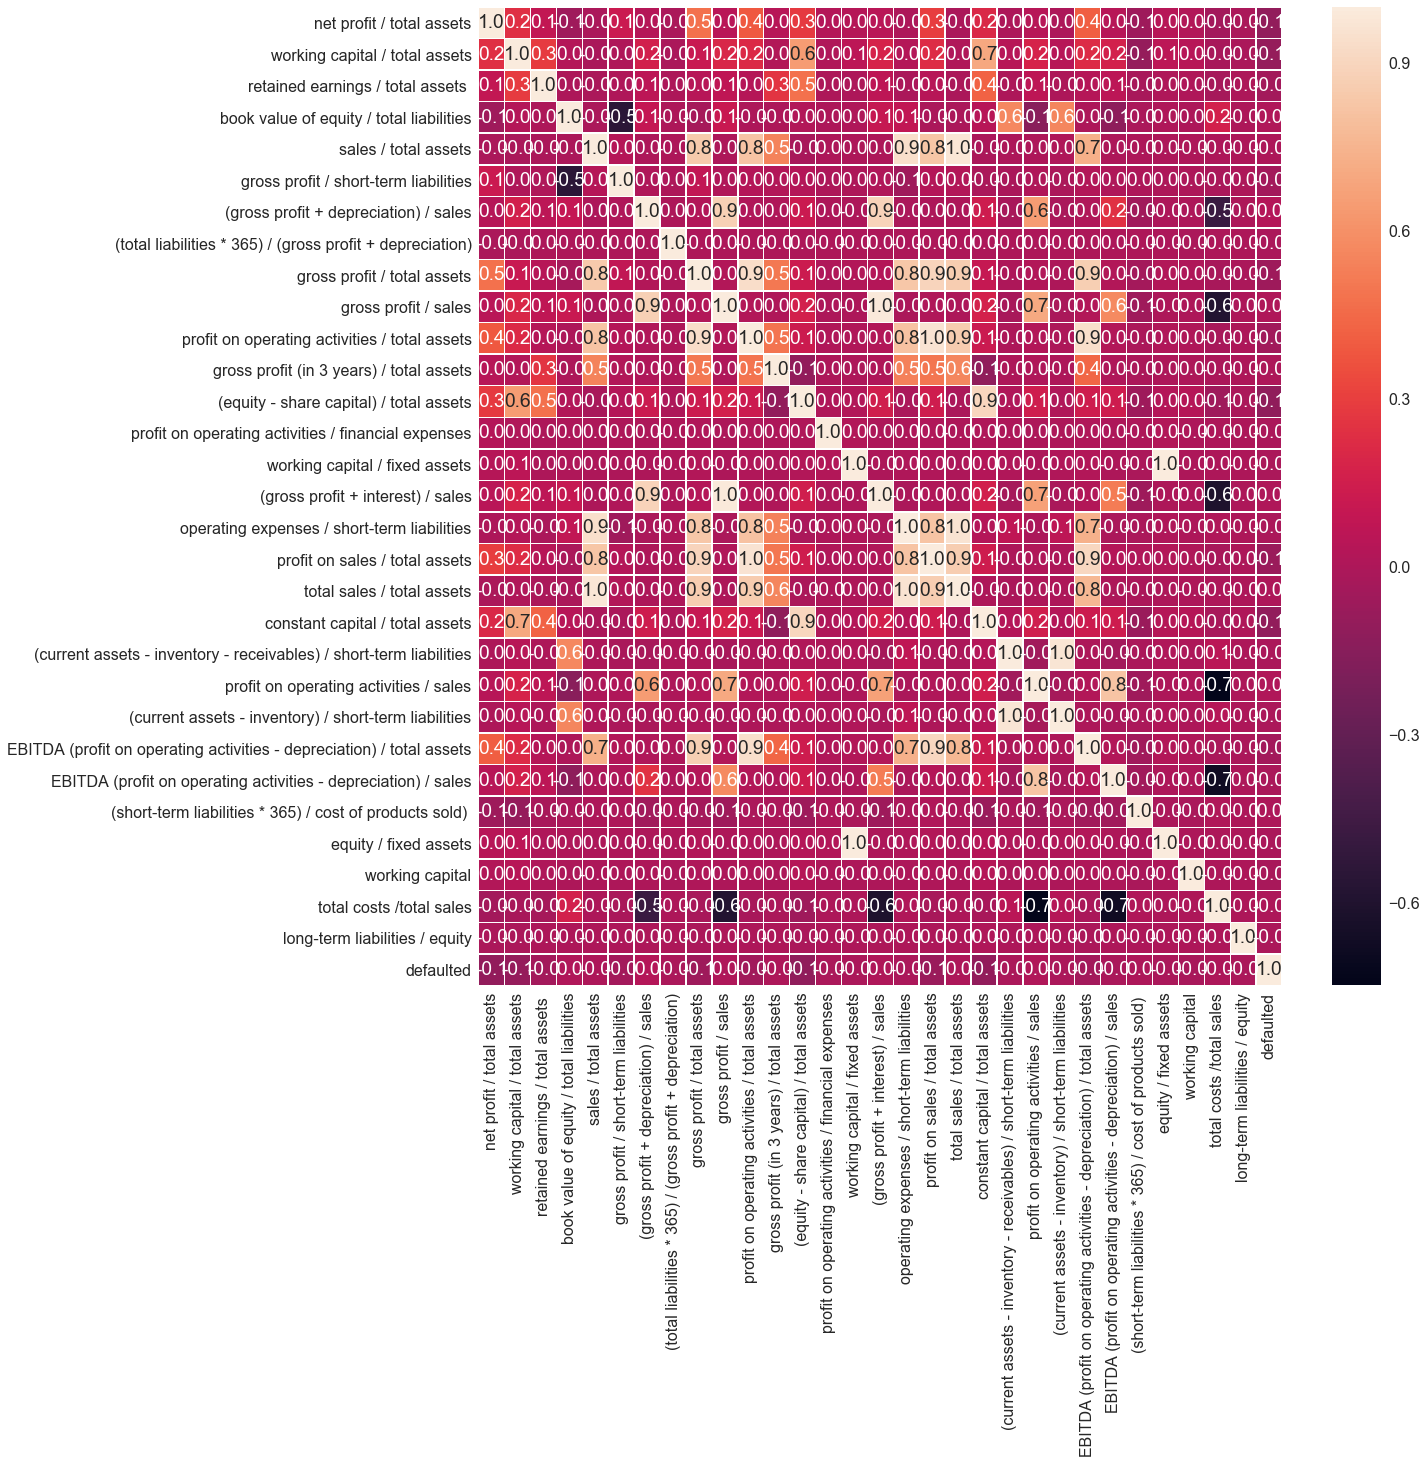

In [109]:
sns.set(font_scale=1.6)
f,ax = plt.subplots(figsize=(18, 18))
sns.heatmap(data.corr(), annot=True, linewidths=.5, fmt= '.1f',ax=ax)

From the heatmap of the correlation we can tell that there are five pairs of features which are strongly correlated (having correlation coeficient = 1.0), which are: __gros profit+interest/sales__ VS __gross profit/sales__, __profit on sales/total_assets__ VS __profit on operating activities/total_assets__, __total sales/total_assets__ VS __sales/total_assets__, __(current assets - inventory - receivable)/short_term liability__ VS __(current assets - inventory)/short_term liability__ and __equity/fixed assets__ VS __working capital/fixed assets__. We only keep one feature out of each pair, so after dropping 5 columns, we now have 25 features in total

In [110]:
droplist=['working capital / fixed assets','(gross profit + interest) / sales', 
          'profit on operating activities / sales','total sales / total assets',
         '(current assets - inventory - receivables) / short-term liabilities']
data = data.drop(columns = droplist, axis=1)


In [111]:
data.describe()

net profit / total assets  working capital / total assets  \
count                5000.000000                     5000.000000   
mean                    0.034363                        0.167935   
std                     0.309707                        0.788338   
min                    -9.298100                      -24.431000   
25%                     0.000280                        0.014754   
50%                     0.038332                        0.195565   
75%                     0.106575                        0.416492   
max                     9.803700                       22.769000   

       retained earnings / total assets   \
count                        5000.000000   
mean                           -0.048330   
std                             2.456970   
min                           -53.802000   
25%                            -0.002098   
50%                             0.000000   
75%                             0.060596   
max                           137.050000   

       book value of equity / total liabilities  sales / total assets  \
count                               5000.000000           5000.000000   
mean                                   6.212618              2.095716   
std                                   70.808749             24.695170   
min                                   -1.848200             -0.000014   
25%                                    0.401515              1.003200   
50%                                    1.055550              1.160250   
75%                                    2.668800              1.970325   
max                                 2800.000000           1704.800000   

       gross profit / short-term liabilities  \
count                            5000.000000   
mean                               -1.007987   
std                                91.569387   
min                             -6331.800000   
25%                                 0.001919   
50%                                 0.128520   
75%                                 0.486645   
max                               342.550000   

       (gross profit + depreciation) / sales  \
count                            5000.000000   
mean                               -0.015861   
std                                19.464510   
min                              -788.110000   
25%                                 0.017844   
50%                                 0.060523   
75%                                 0.124240   
max                               804.400000   

       (total liabilities * 365) / (gross profit + depreciation)  \
count                                       5.000000e+03           
mean                                        4.578087e+03           
std                                         1.367546e+05           
min                                        -1.570000e+06           
25%                                         1.932025e+02           
50%                                         8.888150e+02           
75%                                         2.517450e+03           
max                                         8.090000e+06           

       gross profit / total assets  gross profit / sales  \
count                  5000.000000           5000.000000   
mean                      0.054917             -0.205809   
std                       0.629279             15.894461   
min                      -9.298100           -788.110000   
25%                       0.001023              0.000591   
50%                       0.044727              0.028353   
75%                       0.123120              0.080342   
max                      38.618000            305.500000   

       profit on operating activities / total assets  \
count                                    5000.000000   
mean                                        0.067125   
std                                         0.649025   
min                                        -8.966700   
25%                                    

Look at the statistics of the remaining columns briefly. If we pay attention to the min and max values comparing to the mean and the first three quantiles, we will notice that for every column, there are extreme data points that are far away from center of the data. The following boxplot makes this point even clearer: the distributions of the data are long-tailed.

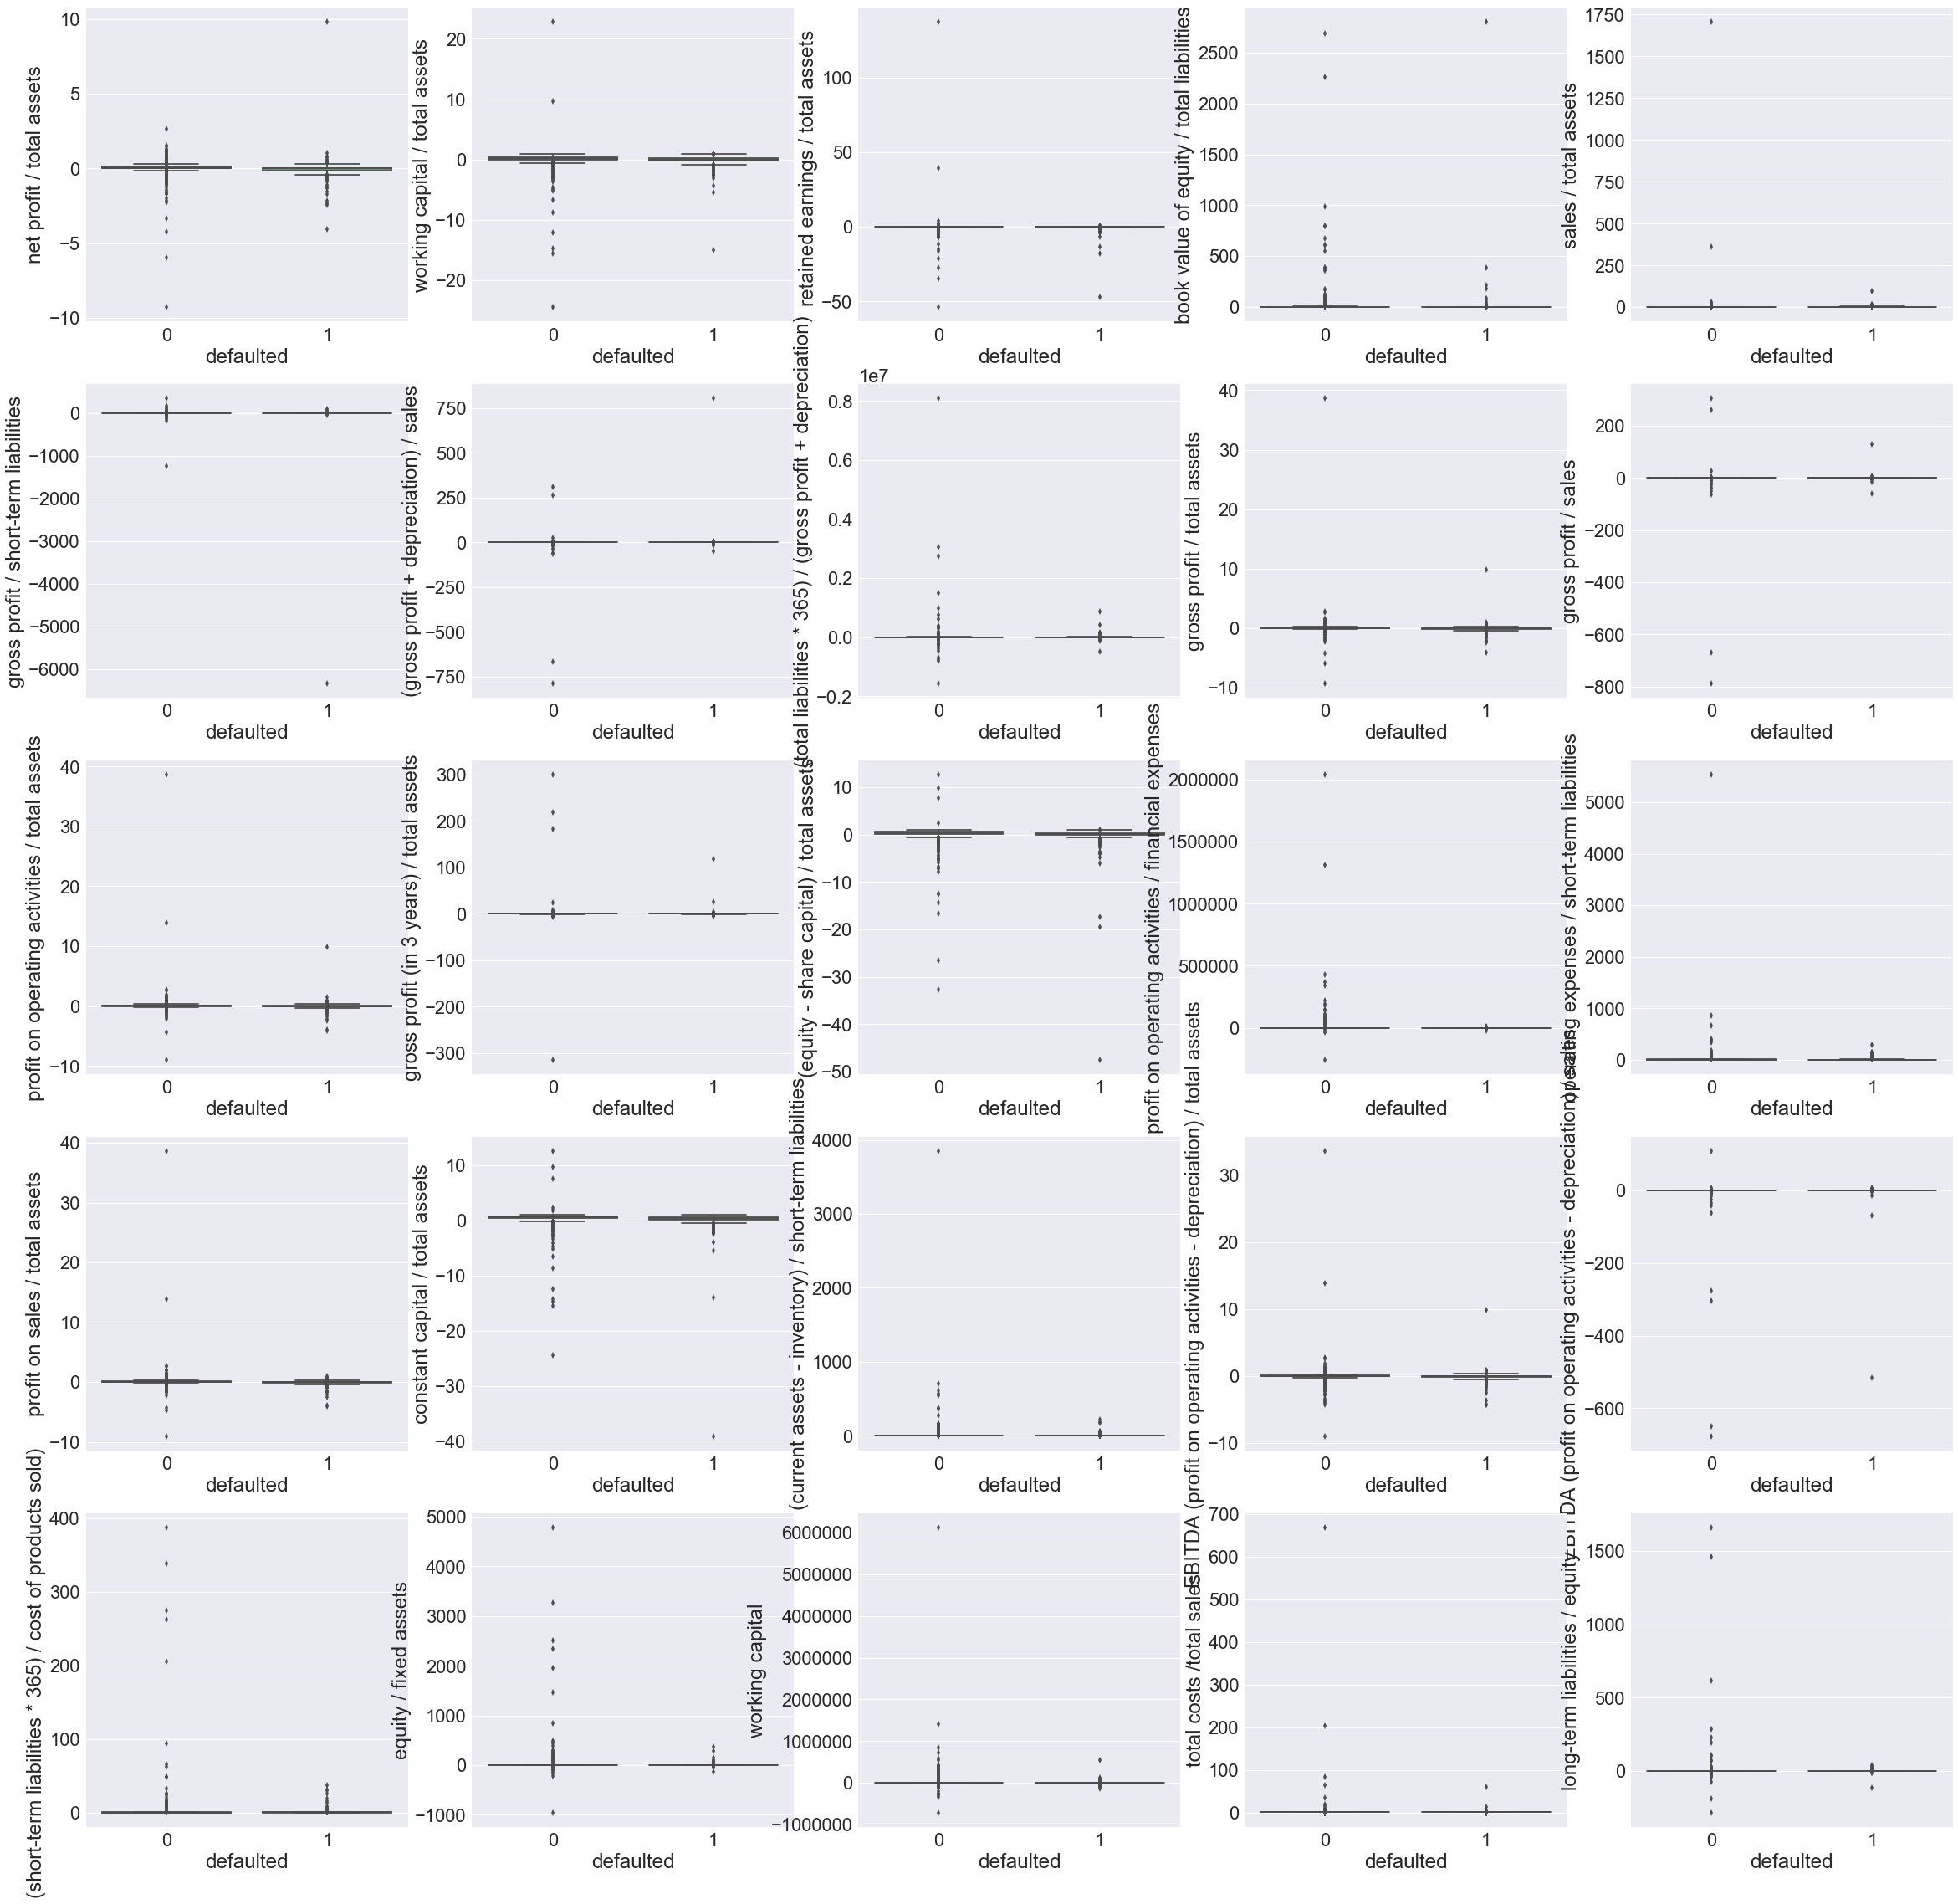

In [104]:
# List of feature variables
features = data.drop(columns='defaulted',axis=1).columns 
sns.set(font_scale=2.2)
plt.figure(figsize=(40,40))
for i in range(len(features)):
    plt.subplot(5,5,i+1)
    ax = sns.boxplot(x='defaulted', y=features[i], data=data)


For data falling into the regime of long-tails in the distribution, we are not sure whether they are true outliers (mislabeled or simply wrong data) or they are just part of the real distribution. Here for simplicity, we refer to those data points as __'outliers'__ with quotation mark. As a way of checking, I simply apply a random forest classifier on the raw dataset as well as on a dataset that replace the 'outliers' of each column with its median value, then compare the two results. <br>
For imbalanced data, accuracy is not a good measuring metric anymore. Instead we can consider __precision__, __recall__, __f1 score__, which counts for both the precision and recall, as well as the __roc curve__ and __auc__ as a replacement.  Here we chose __f1_score__ as the evaluating metric 


In [112]:
from sklearn.ensemble import RandomForestClassifier 
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.model_selection import cross_val_score

X_train, X_test, y_train, y_test = train_test_split(data[features], 
                                                    data['defaulted'])
clf = RandomForestClassifier().fit(X_train, y_train)
scores = cross_val_score(clf, data[features], data['defaulted'],
                         scoring='f1', cv=5)
print("f1 score of the raw data:", scores.mean(), scores.std())


f1 score of the raw data: 0.3427970795883806 0.041270296831505564


Note that the __replace_outlier()__ function replaces the data points which are out of the 2%-98% quantile range with the meadian value 



In [113]:
def replace_outlier(df_in, col_name):
    lower_bound = df_in[col_name].quantile(0.02)
    median = df_in[col_name].quantile(0.5)
    upper_bound = df_in[col_name].quantile(0.98)
    df_in.loc[(df_in[col_name] < lower_bound) | (df_in[col_name] > upper_bound),
              col_name] = median

data_rm = data.copy()
features = data.drop(columns='defaulted').columns
for col_name in features:
     replace_outlier(data_rm, col_name)


X_train, X_test, y_train, y_test = train_test_split(data_rm[features], 
                                                    data_rm['defaulted'])
clf = RandomForestClassifier().fit(X_train, y_train)
scores = cross_val_score(clf, data_rm[features], data_rm['defaulted'],
                         scoring='f1', cv=5)
print("f1 score of the processed data:", scores.mean(), scores.std())




f1 score of the processed data: 0.3341749817879991 0.03286186206368921


Results tested on the two data sets (with and without replacing the 'outliers') do not show qualititive difference, so in the following part of the analysis, I just keep the original data points without dealing with the 'outliers'. 
However, before we move on to next step, we can look at again the box plots of the preivously processed data after replacing the 'outliers' with the median, as now the plots enables us to compare the distributions of centered data for the two classes in a better way

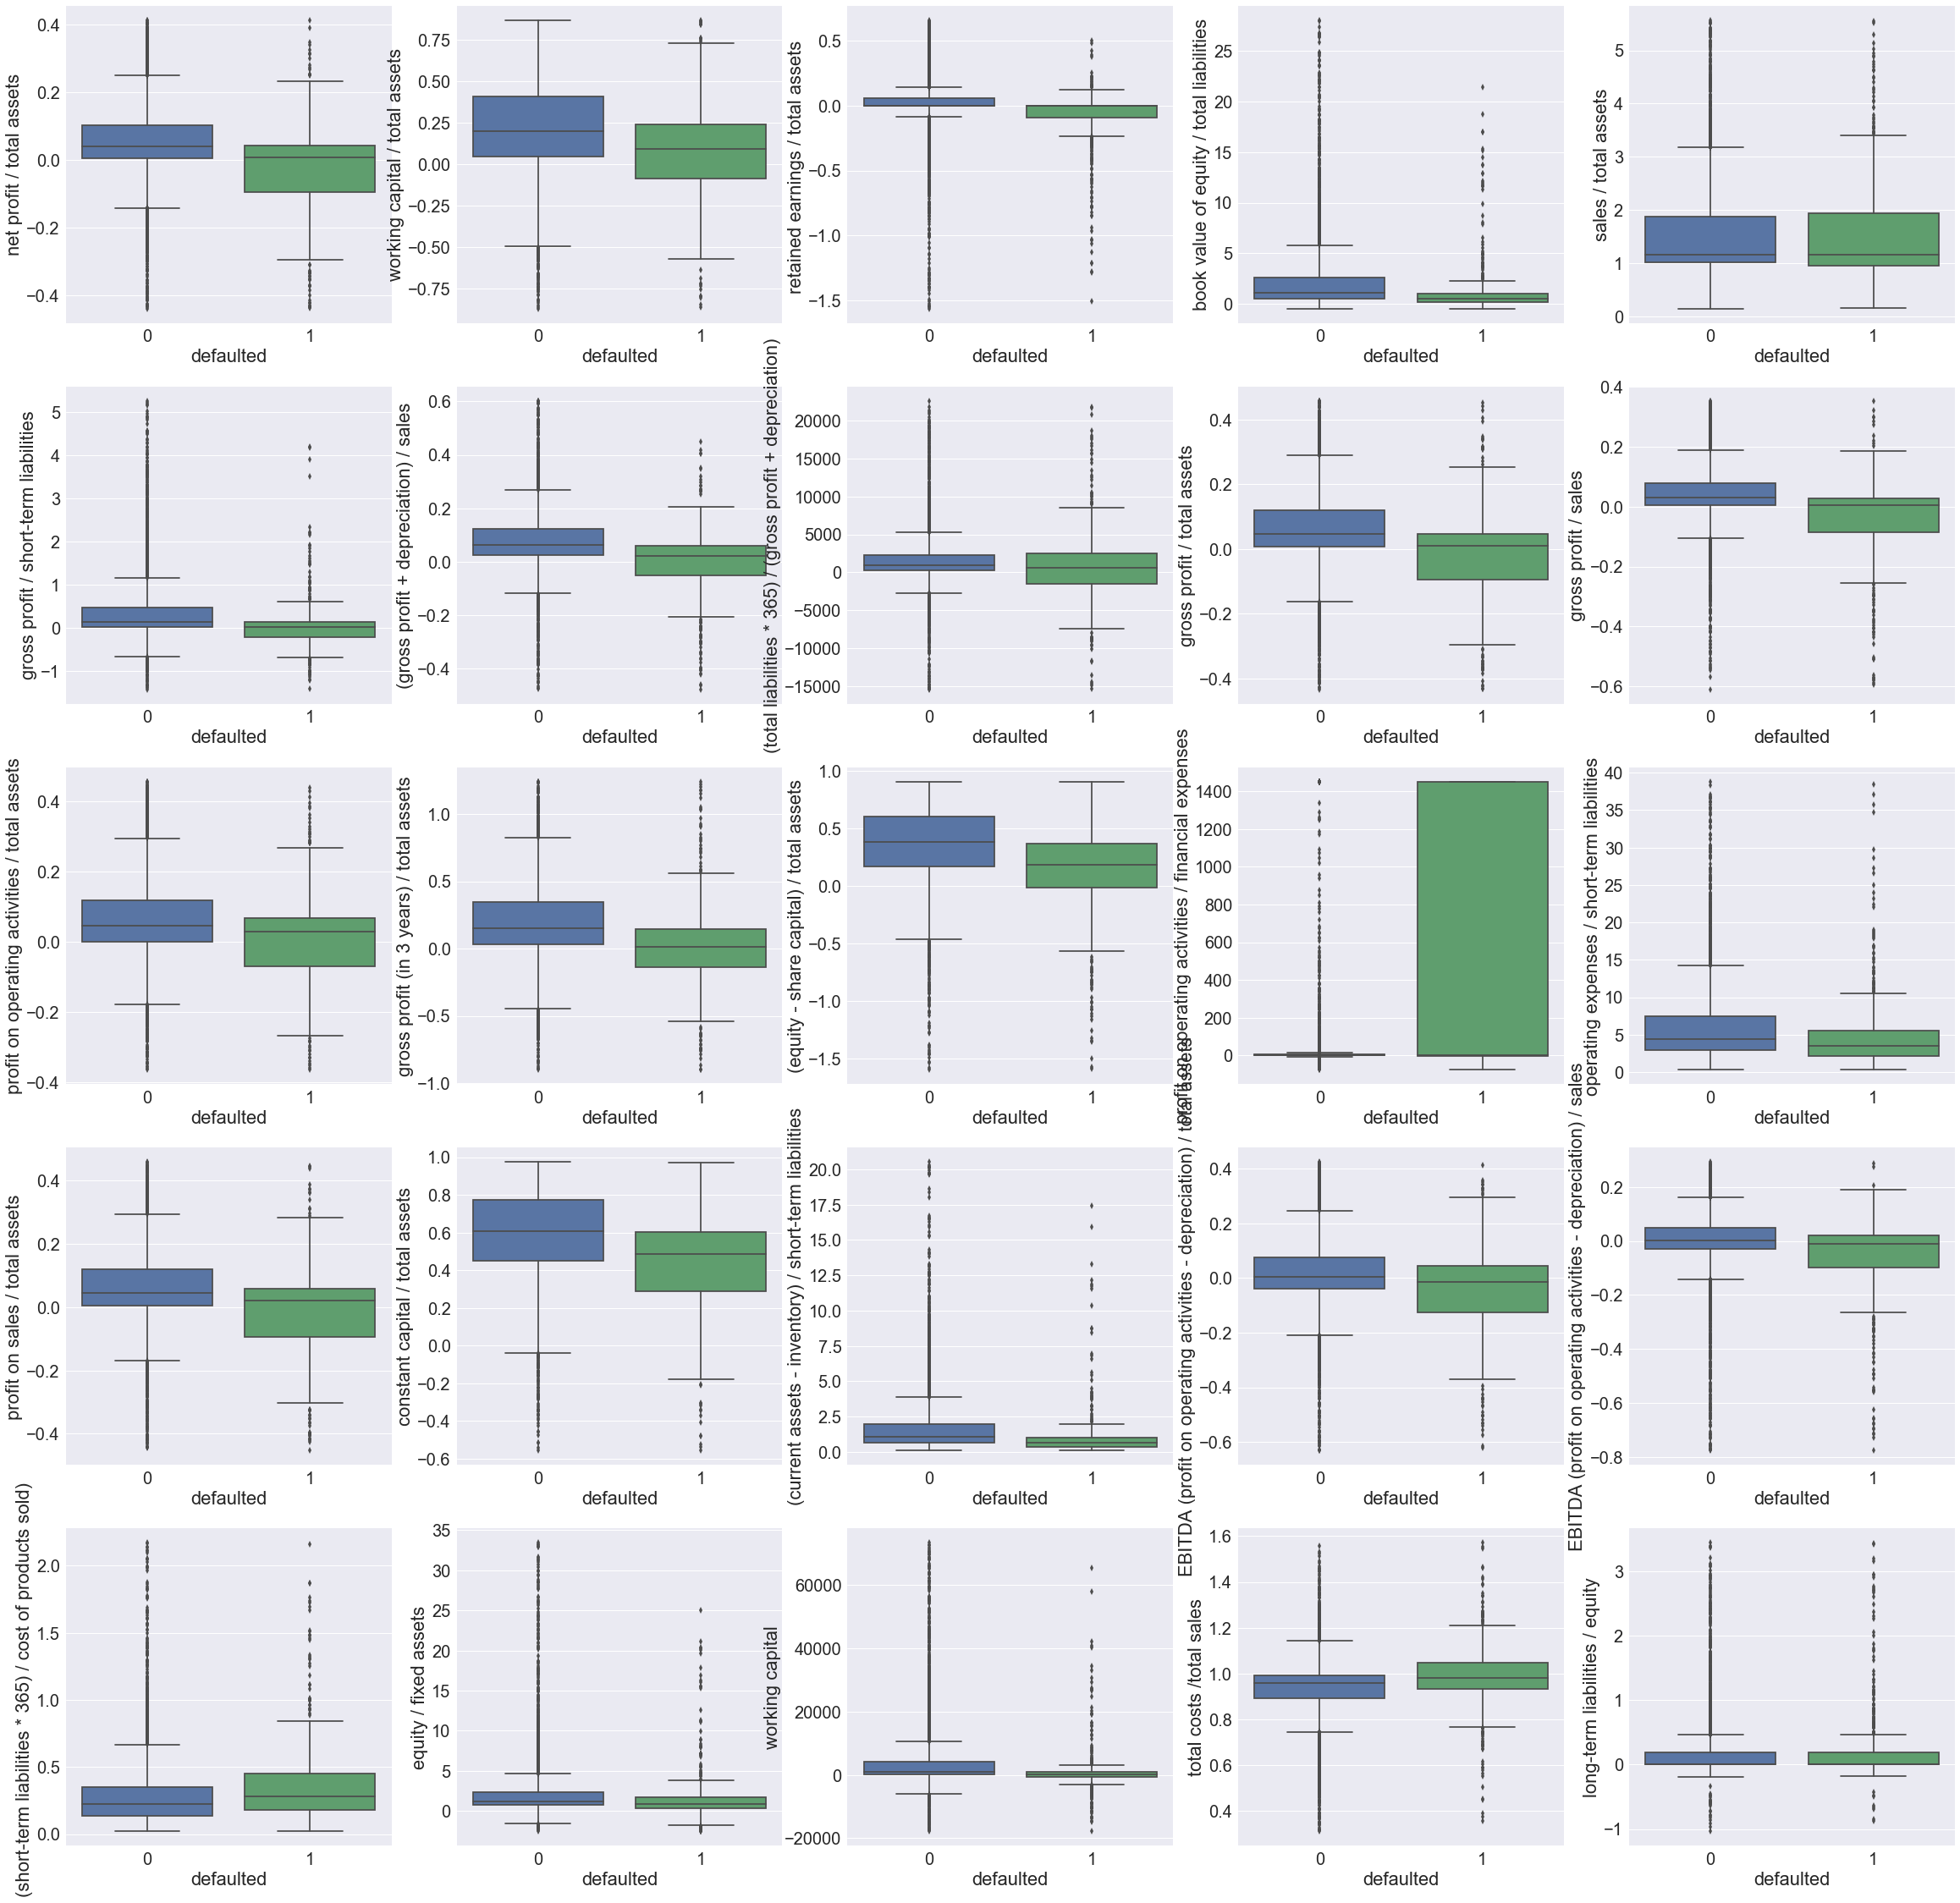

In [10]:
sns.set(font_scale=2.0)
plt.figure(figsize=(40,40))
for i in range(len(features)):
    plt.subplot(5,5,i+1)
    ax = sns.boxplot(x='defaulted', y=features[i], data=data_rm)


We observe a clear difference between the two classes on the feature __profit on operating activities/financial expenses__. For the other features, there are also some differences but less apparent. <br>
If time allows, I would like to try sampling data points within each feature into two groups: the centered data and the data from the tails, then independently examine how they would influnence the classification results


# 3. Model Building

## Feature Selection with Random Forest 




Before building the model, I would like to get ride of more features and keep fewer of them using Random Froest. Selecting fewer features can simplify the final model, reduce computation time as well as improve the accuracy by eliminating irrelevant features. In the following cell, I print and plot out the feature importance for each feature based on the evaluation of Random Forest

Feature ranking:
1. feature 13 (0.087117)
2. feature 17 (0.073966)
3. feature 11 (0.057881)
4. feature 15 (0.047807)
5. feature 23 (0.046265)
6. feature 7 (0.045600)
7. feature 2 (0.044540)
8. feature 6 (0.044370)
9. feature 16 (0.043040)
10. feature 12 (0.039892)
11. feature 10 (0.038077)
12. feature 9 (0.035949)
13. feature 22 (0.035226)
14. feature 3 (0.035064)
15. feature 21 (0.035012)
16. feature 4 (0.032640)
17. feature 19 (0.031841)
18. feature 18 (0.030573)
19. feature 0 (0.030548)
20. feature 8 (0.029683)
21. feature 5 (0.027776)
22. feature 14 (0.027537)
23. feature 20 (0.027381)
24. feature 1 (0.026770)
25. feature 24 (0.025446)


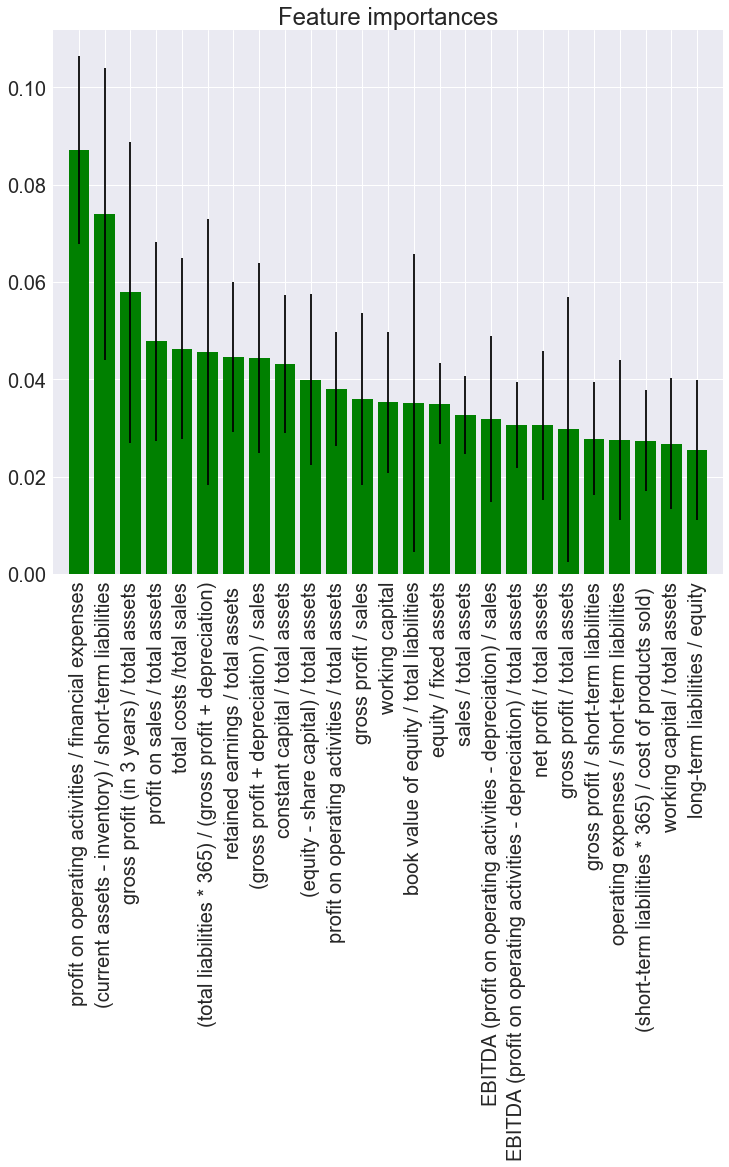

In [29]:
X_train, X_test, y_train, y_test = train_test_split(data[features], 
                                                    data['defaulted'])
clf = RandomForestClassifier()     
clf = clf.fit(X_train,y_train)
importances = clf.feature_importances_
std = np.std([tree.feature_importances_ for tree in clf.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(X_train.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

# Plot the feature importances of the forest

plt.figure(1, figsize=(12, 10))
plt.title("Feature importances")
plt.bar(range(X_train.shape[1]), importances[indices],
       color="g", yerr=std[indices], align="center")
plt.xticks(range(X_train.shape[1]), X_train.columns[indices],rotation=90)
plt.xlim([-1, X_train.shape[1]])
plt.show()

As shown above, one of the most important feature is __profit on operating activities/financial expenses__, which is in accordance with our observation through the box plots above. Even though there is no clear cut between the important and non-important features, as the curve looks quite flat at the tail, here I would just select the 10 most important features

In [30]:
selected_features = X_train.columns[indices[0:10]]

## Selecting Random Forest as the model

As pointed out previously, this dataset is imbalanced. As Random Forest is more robust against imbalanced dataset. I hereby chose Random Forest as my machine learning algorithm. <br>
For future work, it is also worth to try techniques of sampling imbalanced data, like __over-sampling__ etc, as well as other machine learning algorithms. 

### Tuning parameters

To optimize the performance of the model, I applied Grid search with 3-fold cross validation to find the best parameters of __n_estimators__ and __max_depth__ for the Random Forest model

In [13]:
from sklearn.model_selection import GridSearchCV  

X_train, X_test, y_train, y_test = train_test_split(data[selected_features], data['defaulted'])
clf=RandomForestClassifier(class_weight = 'balanced')
param_grid = {'n_estimators': [50, 300, 500], 'max_depth' : [6,7,8,9,10]}
CV_rfc = GridSearchCV(estimator=clf, param_grid=param_grid, cv=3,scoring='f1')
CV_rfc.fit(X_train, y_train)
print(CV_rfc.best_params_)
print(CV_rfc.best_score_)

{'max_depth': 6, 'n_estimators': 300}
0.43262240695931004


In [14]:
clf_optimized = RandomForestClassifier(max_depth = CV_rfc.best_params_['max_depth'], 
                                n_estimators =CV_rfc.best_params_['n_estimators'],class_weight = 'balanced' )

Apply the optimized parameters for the Random Forest model and measure the cross validation scores with __f1 score__ and __roc_auc score__ correspondingly. Final results are __roc_auc=0.885(7)__ and __f1 score=0.43(3)__

In [203]:
scores = cross_val_score(clf_optimized, data[selected_features], data['defaulted'],
                         scoring='f1', cv=5)
print('f1 score:', scores.mean(), scores.std())
scores = cross_val_score(clf_optimized, data[selected_features], data['defaulted'],
                         scoring='roc_auc', cv=5)
print('roc_auc score:', scores.mean(), scores.std())

f1 score: 0.472567141631474 0.025249347940135537
roc_auc score: 0.8574244444444444 0.008311727249888741


# 4. Summary

In this excercise, I worked on the financial data of 5000 corporates and tried to predict whether one company will default or not. I employed exploratary data analysis, feature selection as well as machine learning models with optimization to make the prediction, achieving __roc_auc = 0.885(7)__ and __f1 = 0.43(3)__.

With limited time, I could not try out more apporaches to improve the results. However, as next steps, I have a few ideas to work on later which may help improving the results.<br>
__(1) Applying sampling techniques for imbalanced data.__ For example, we can use bootstrpping to over-sample the positive class, such that the instances of the two classes will get more balanced. <br>
__(2) Optimizing the cut-off probability when making predictions.__ For imbalanced class, the default (0.5) cut_off probability may not be the best value in making correct predictions. We can try to define a new scoring function with varying cut-off values and pick the one that maximizes the results of predictions. <br>
__(3) Smart ways to deal with the 'outlier' data points.__ In this excercise, these 'outliers' seem harmless and most likely they refelect the genuine distribution of the data points. However, the 'outlier' and the more centered data points seem to follow rather different distributions. We can try to divide them into two groups and consider seperately.<br>
__(4) Trying other algorithms__, such as SVM with kernels as well as gradient boosting trees, while employing the approaches mentioned above.

# Supplementary work

### Performance of Logistic Regression & SVM & KNN

In [14]:
features

Index(['net profit / total assets', 'working capital / total assets',
       'retained earnings / total assets ',
       'book value of equity / total liabilities', 'sales / total assets',
       'gross profit / short-term liabilities',
       '(gross profit + depreciation) / sales',
       '(total liabilities * 365) / (gross profit + depreciation)',
       'gross profit / total assets', 'gross profit / sales',
       'profit on operating activities / total assets',
       'gross profit (in 3 years) / total assets',
       '(equity - share capital) / total assets',
       'profit on operating activities / financial expenses',
       'operating expenses / short-term liabilities',
       'profit on sales / total assets', 'constant capital / total assets',
       '(current assets - inventory) / short-term liabilities',
       'EBITDA (profit on operating activities - depreciation) / total assets',
       'EBITDA (profit on operating activities - depreciation) / sales',
       '(short-term

In [53]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

X_train, X_test, y_train, y_test = train_test_split(data[selected_features], 
                                                    data['defaulted'], random_state=10)
scaler = StandardScaler()
data_trans = data.copy()
data_trans[selected_features] = scaler.fit_transform(data[selected_features])

clf=LogisticRegression()

scores = cross_val_score(clf, data_trans[selected_features], data['defaulted'],
                         scoring='f1', cv=5)
print('f1 score with selected features', scores.mean(), scores.std())

scores = cross_val_score(clf, data_trans[selected_features], data['defaulted'],
                         scoring='roc_auc', cv=5)
print('roc_auc score with selected features', scores.mean(), scores.std())

scores = cross_val_score(clf, data_trans[features], data['defaulted'],
                         scoring='f1', cv=5)
print('f1 score with all features', scores.mean(), scores.std())

scores = cross_val_score(clf, data_trans[features], data['defaulted'],
                         scoring='roc_auc', cv=5)
print('roc_auc score with all features', scores.mean(), scores.std())

f1 score with selected features 0.0341122631383712 0.021908513772700904
roc_auc score with selected features 0.6901177777777778 0.02290209069112882
f1 score with all features 0.033659979164566325 0.021276120374787585
roc_auc score with all features 0.6268022222222221 0.03347527585886575


In [ ]:
from sklearn import 

In [54]:
from sklearn.svm import SVC

X_train, X_test, y_train, y_test = train_test_split(data[selected_features], 
                                                    data['defaulted'])
clf=SVC()
scores = cross_val_score(clf, data_trans[selected_features], data['defaulted'],
                         scoring='f1', cv=5)
print('f1 score with selected features', scores.mean(), scores.std())

scores = cross_val_score(clf, data_trans[selected_features], data['defaulted'],
                         scoring='roc_auc', cv=5)
print('roc_auc score with selected features', scores.mean(), scores.std())

scores = cross_val_score(clf, data_trans[features], data['defaulted'],
                         scoring='f1', cv=5)
print('f1 score with all features', scores.mean(), scores.std())

scores = cross_val_score(clf, data_trans[features], data['defaulted'],
                         scoring='roc_auc', cv=5)
print('roc_auc score with all  features', scores.mean(), scores.std())





/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


f1 score with selected features 0.0 0.0
roc_auc score with selected features 0.6810944444444444 0.03460557651486143
f1 score with all features 0.015498814910579617 0.007752457460943384
roc_auc score with all  features 0.5265977777777778 0.01339592005328763


From the results we can tell that logistic regression and SVC did poorly on the algorithm


### Performance with Gradient boosting trees
There is no class_weight parameter for GBT





In [16]:
from sklearn.ensemble import GradientBoostingClassifier

X_train, X_test, y_train, y_test = train_test_split(data[selected_features], data['defaulted'])
clf=GradientBoostingClassifier()
param_grid = {'learning_rate': [0.05,0.1,0.5,1], 'max_depth' : [5,6,7,8]}
CV_clf = GridSearchCV(estimator=clf, param_grid=param_grid, cv=3,scoring='f1')
CV_clf.fit(X_train, y_train)
print(CV_clf.best_params_)
print(CV_clf.best_score_)

{'learning_rate': 1, 'max_depth': 5}
0.430491263477614


In [17]:
clf_optimized = GradientBoostingClassifier(max_depth = CV_clf.best_params_['max_depth'], 
                                learning_rate =CV_clf.best_params_['learning_rate'])
scores = cross_val_score(clf_optimized, data[selected_features], data['defaulted'],
                         scoring='f1', cv=5)
print('f1 score:', scores.mean(), scores.std())
scores = cross_val_score(clf_optimized, data[selected_features], data['defaulted'],
                         scoring='roc_auc', cv=5)
print('roc_auc score:', scores.mean(), scores.std())



f1 score: 0.42484710080962823 0.05744472360511261
roc_auc score: 0.8100377777777776 0.026903021630283602


### Self-defined cut-off function

In [183]:
def cutoff_predict(clf, X, cutoff):
    return ((clf.predict_proba(X)[:,1] > cutoff).astype(int))
scores = []
def custom_f1(cutoff):
    def f1_cutoff(clf, X, y):
        ypred = cutoff_predict(clf, X, cutoff)
        return f1_score(y, ypred)
    return f1_cutoff



In [17]:
X_train, X_test, y_train, y_test = train_test_split(data[selected_features], data['defaulted'],random_state=10)
clf = RandomForestClassifier()
param_grid = {'n_estimators': [50, 300, 500], 'max_depth' : [6,7,8,9,10]}
CV_rfc = GridSearchCV(estimator=clf, param_grid=param_grid, cv=5,scoring='f1')
CV_rfc.fit(X_train, y_train)
print(CV_rfc.best_params_)
print(CV_rfc.best_score_)



{'max_depth': 10, 'n_estimators': 300}
0.41614846753846235


In [182]:
clf_optimized = RandomForestClassifier(n_estimators = CV_rfc.best_params_['n_estimators'],max_depth= CV_rfc.best_params_['max_depth'])
for cutoff in np.arange(0.1,0.9,0.1):
    scores = cross_val_score(clf_optimized,data[selected_features], data['defaulted'],cv=5, scoring = custom_f1(cutoff))
    print('cutoff:', cutoff, 'Self-defined cutoff f1_score:', scores.mean(), scores.std())
    

    

cutoff: 0.1 Self-defined cutoff f1_score: 0.40311152623789004 0.00909239509360706
cutoff: 0.2 Self-defined cutoff f1_score: 0.5198272488067608 0.02515950953863265
cutoff: 0.30000000000000004 Self-defined cutoff f1_score: 0.5077251347780456 0.029618248759256047
cutoff: 0.4 Self-defined cutoff f1_score: 0.453448664484198 0.05045330022076354
cutoff: 0.5 Self-defined cutoff f1_score: 0.3818752639942731 0.0428680192213757
cutoff: 0.6 Self-defined cutoff f1_score: 0.29838231565985807 0.03837041493209819
cutoff: 0.7000000000000001 Self-defined cutoff f1_score: 0.2316451810629733 0.022329591305577722
cutoff: 0.8 Self-defined cutoff f1_score: 0.13347966338792025 0.03178569478269403


By setting the cutoff predicting probability to **0.2/0.3**, insead of previously **0.5**, we can improve the f1_score to be **0.52(3)**, which increased by around **25%**

### Over-sampling Technique
In this session, we try over-sampling with synthetic data **SMOTE** and see if we can improve the results

In [19]:
from imblearn.over_sampling import SMOTE
from sklearn.metrics import f1_score, roc_auc_score
from imblearn.pipeline import make_pipeline
from imblearn.combine import SMOTEENN

X_train, X_test, y_train, y_test = train_test_split(data[selected_features], data['defaulted'],random_state=10)
sm = SMOTE(ratio = 'auto')
X_train_res, y_train_res = sm.fit_sample(X_train, y_train)
clf=RandomForestClassifier()

param_grid = {'n_estimators': [50, 300, 500], 'max_depth' : [6,7,8,9]}

CV_rfc = GridSearchCV(clf, param_grid=param_grid, cv=5, scoring='f1')
CV_rfc.fit(X_train_res, y_train_res)
print(CV_rfc.best_params_)
print(CV_rfc.best_score_)

clf_optimized = RandomForestClassifier(max_depth = CV_rfc.best_params_['max_depth'], 
                                n_estimators =CV_rfc.best_params_['n_estimators'] )
clf_optimized.fit(X_train_res, y_train_res)

# scores = cross_val_score(pipeline_opt, data[selected_features], data['defaulted'],
#                          scoring='f1', cv=5)
# print('f1 score:', scores.mean(), scores.std())
# scores = cross_val_score(pipeline_opt, data[selected_features], data['defaulted'],
#                          scoring='roc_auc', cv=5)
# print('roc_auc score:', scores.mean(), scores.std()

{'max_depth': 9, 'n_estimators': 500}
0.8889097722720481


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=9, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [85]:
print('f1 score:', f1_score(y_test, clf_optimized.predict(X_test)))
print('ROC_AUC score:', roc_auc_score(y_test, clf_optimized.predict(X_test)))

clf_optimized = RandomForestClassifier(max_depth = CV_rfc.best_params_['max_depth'], 
                                n_estimators =CV_rfc.best_params_['n_estimators'] )
scores = []
for i in range(5):
    X_train, X_test, y_train, y_test = train_test_split(data[selected_features], data['defaulted'])
    sm = SMOTE(ratio = 'auto')
    X_train_res, y_train_res = sm.fit_sample(X_train, y_train)
    clf_optimized.fit(X_train_res, y_train_res)
    scores.append(f1_score(y_test, clf_optimized.predict(X_test)))

scores = np.array(scores)
print('f1 score:', scores.mean(), scores.std())

ValueError: Number of features of the model must match the input. Model n_features is 10 and input n_features is 25 

Applying **SMOTE**, the score got improved by **15%**

### Histograms of the data and Special Treatment to  the 'Outliers'

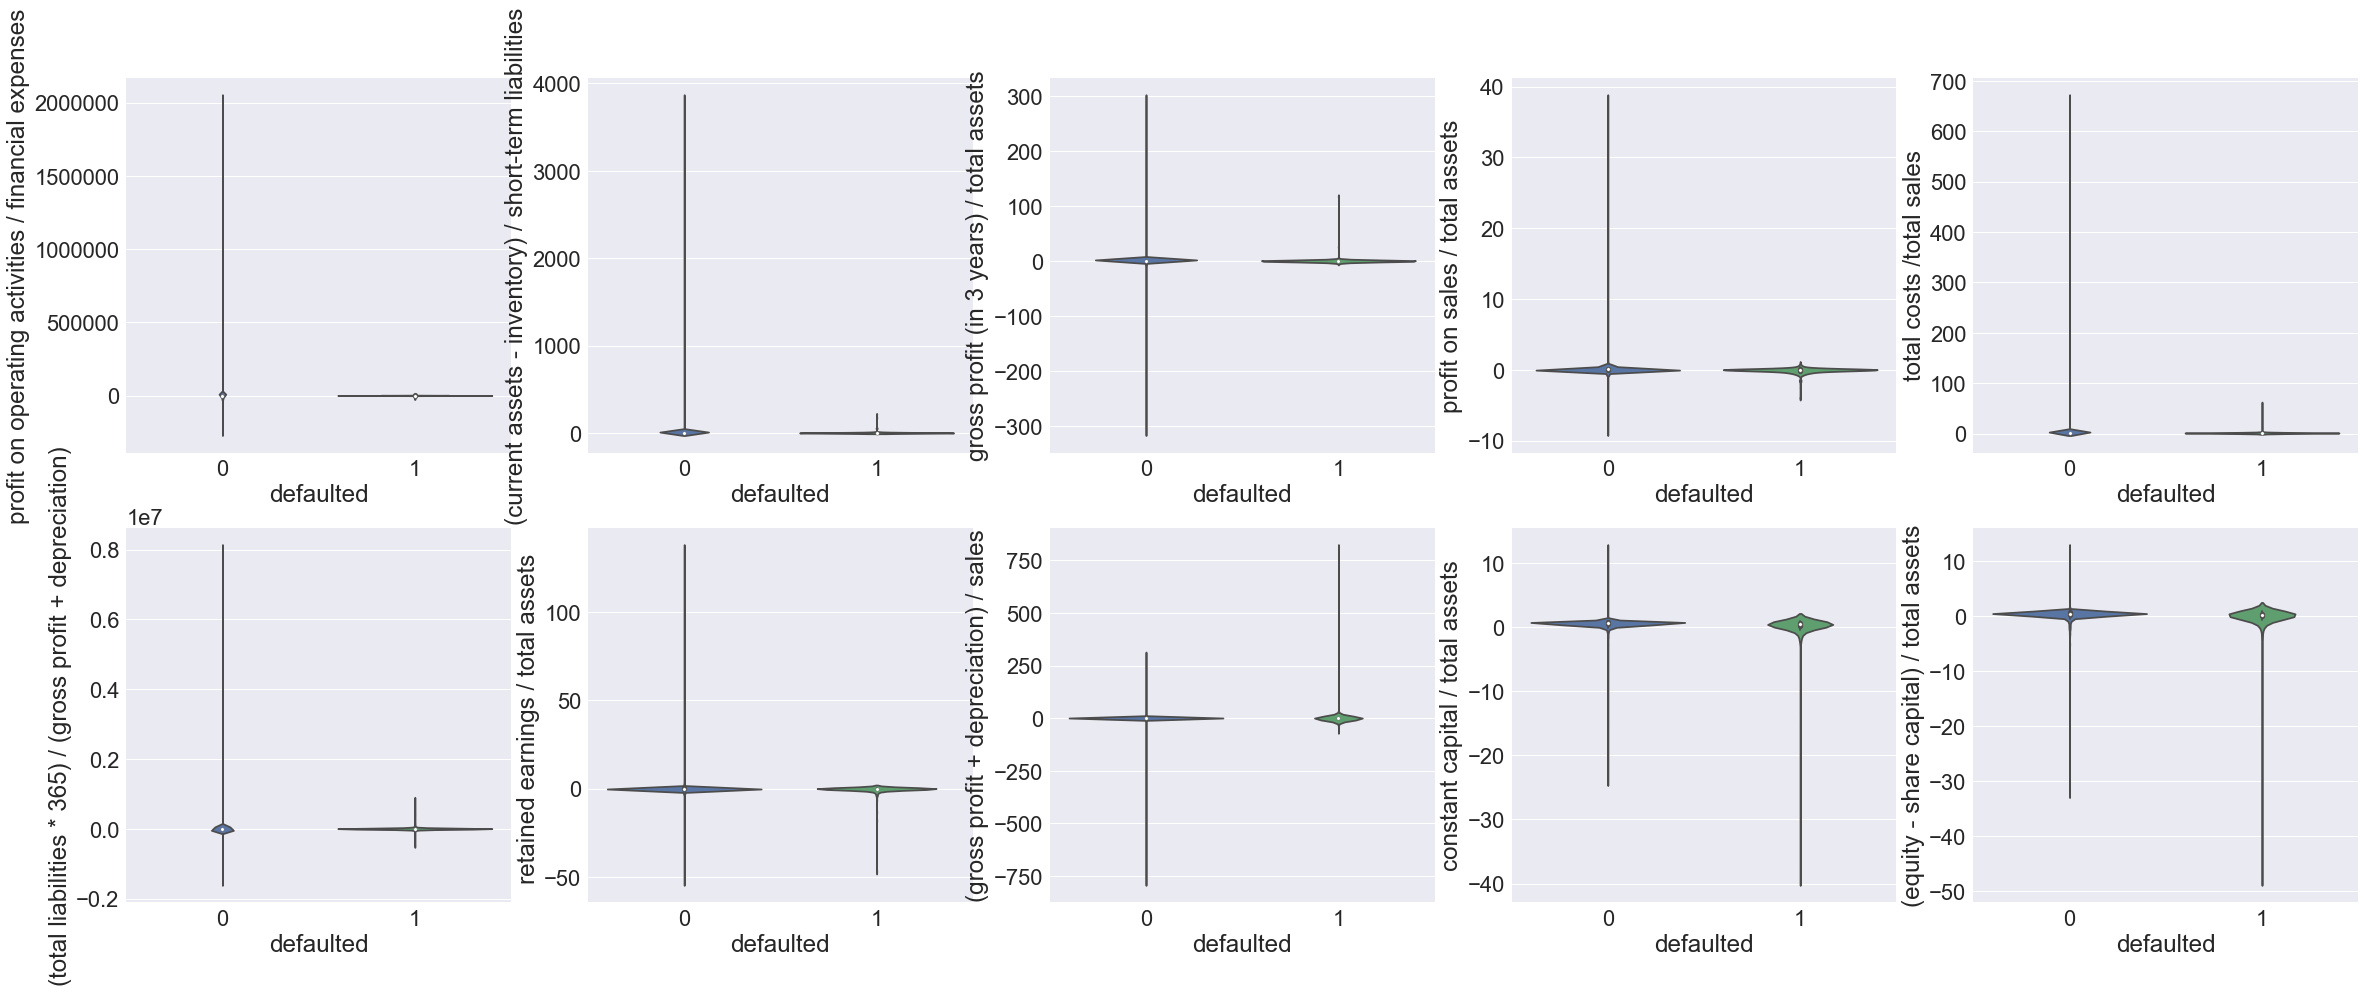

In [69]:
features = data.drop(columns='defaulted',axis=1).columns 
sns.set(font_scale=2.2)
plt.figure(figsize=(40,40))
for i in range(len(selected_features)):
    plt.subplot(5,5,i+1)
    ax = sns.violinplot(x='defaulted', y=selected_features[i], data=data)


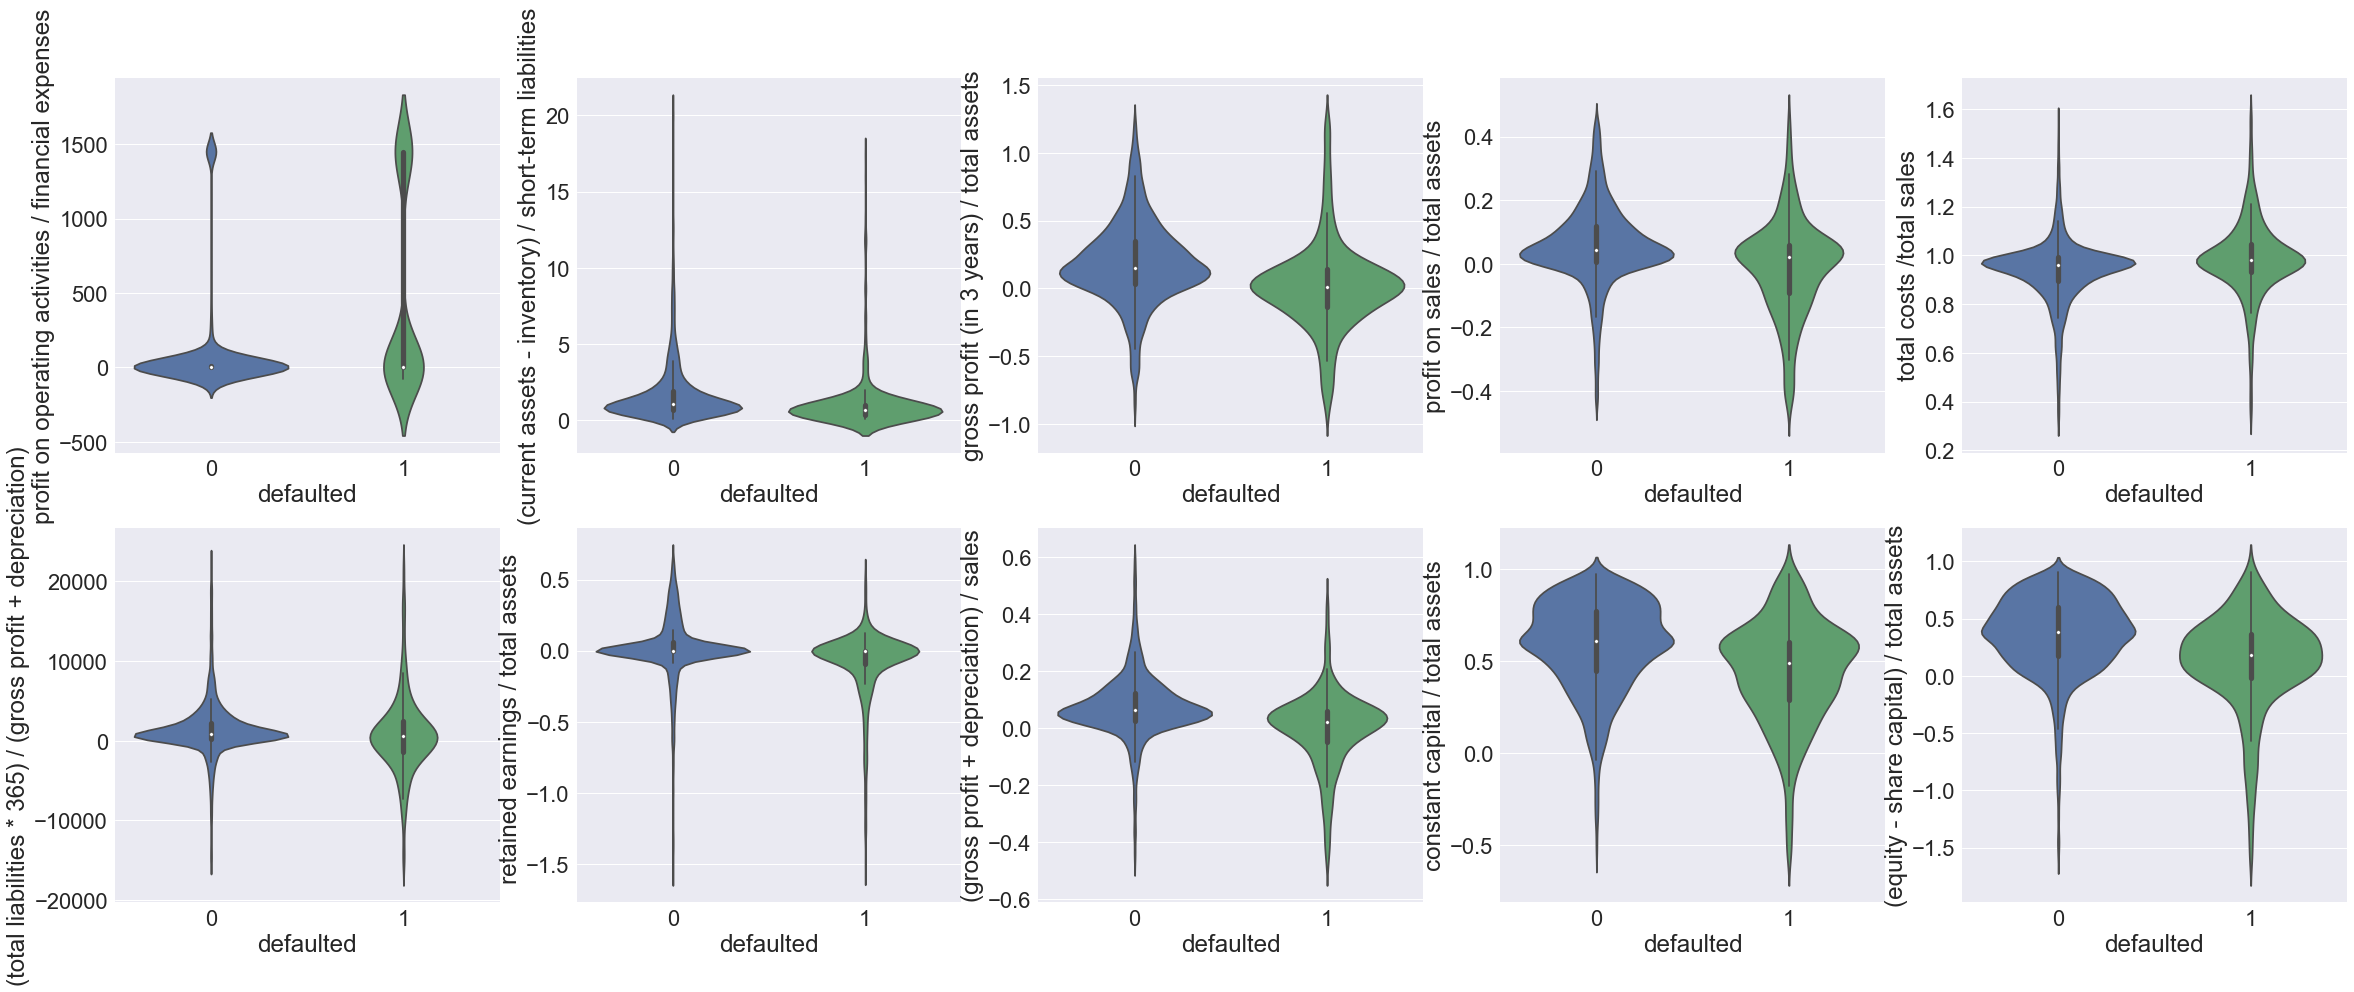

In [70]:
sns.set(font_scale=2.2)
plt.figure(figsize=(40,40))
for i in range(len(selected_features)):
    plt.subplot(5,5,i+1)
    ax = sns.violinplot(x='defaulted', y=selected_features[i], data=data_rm)



### Outliers

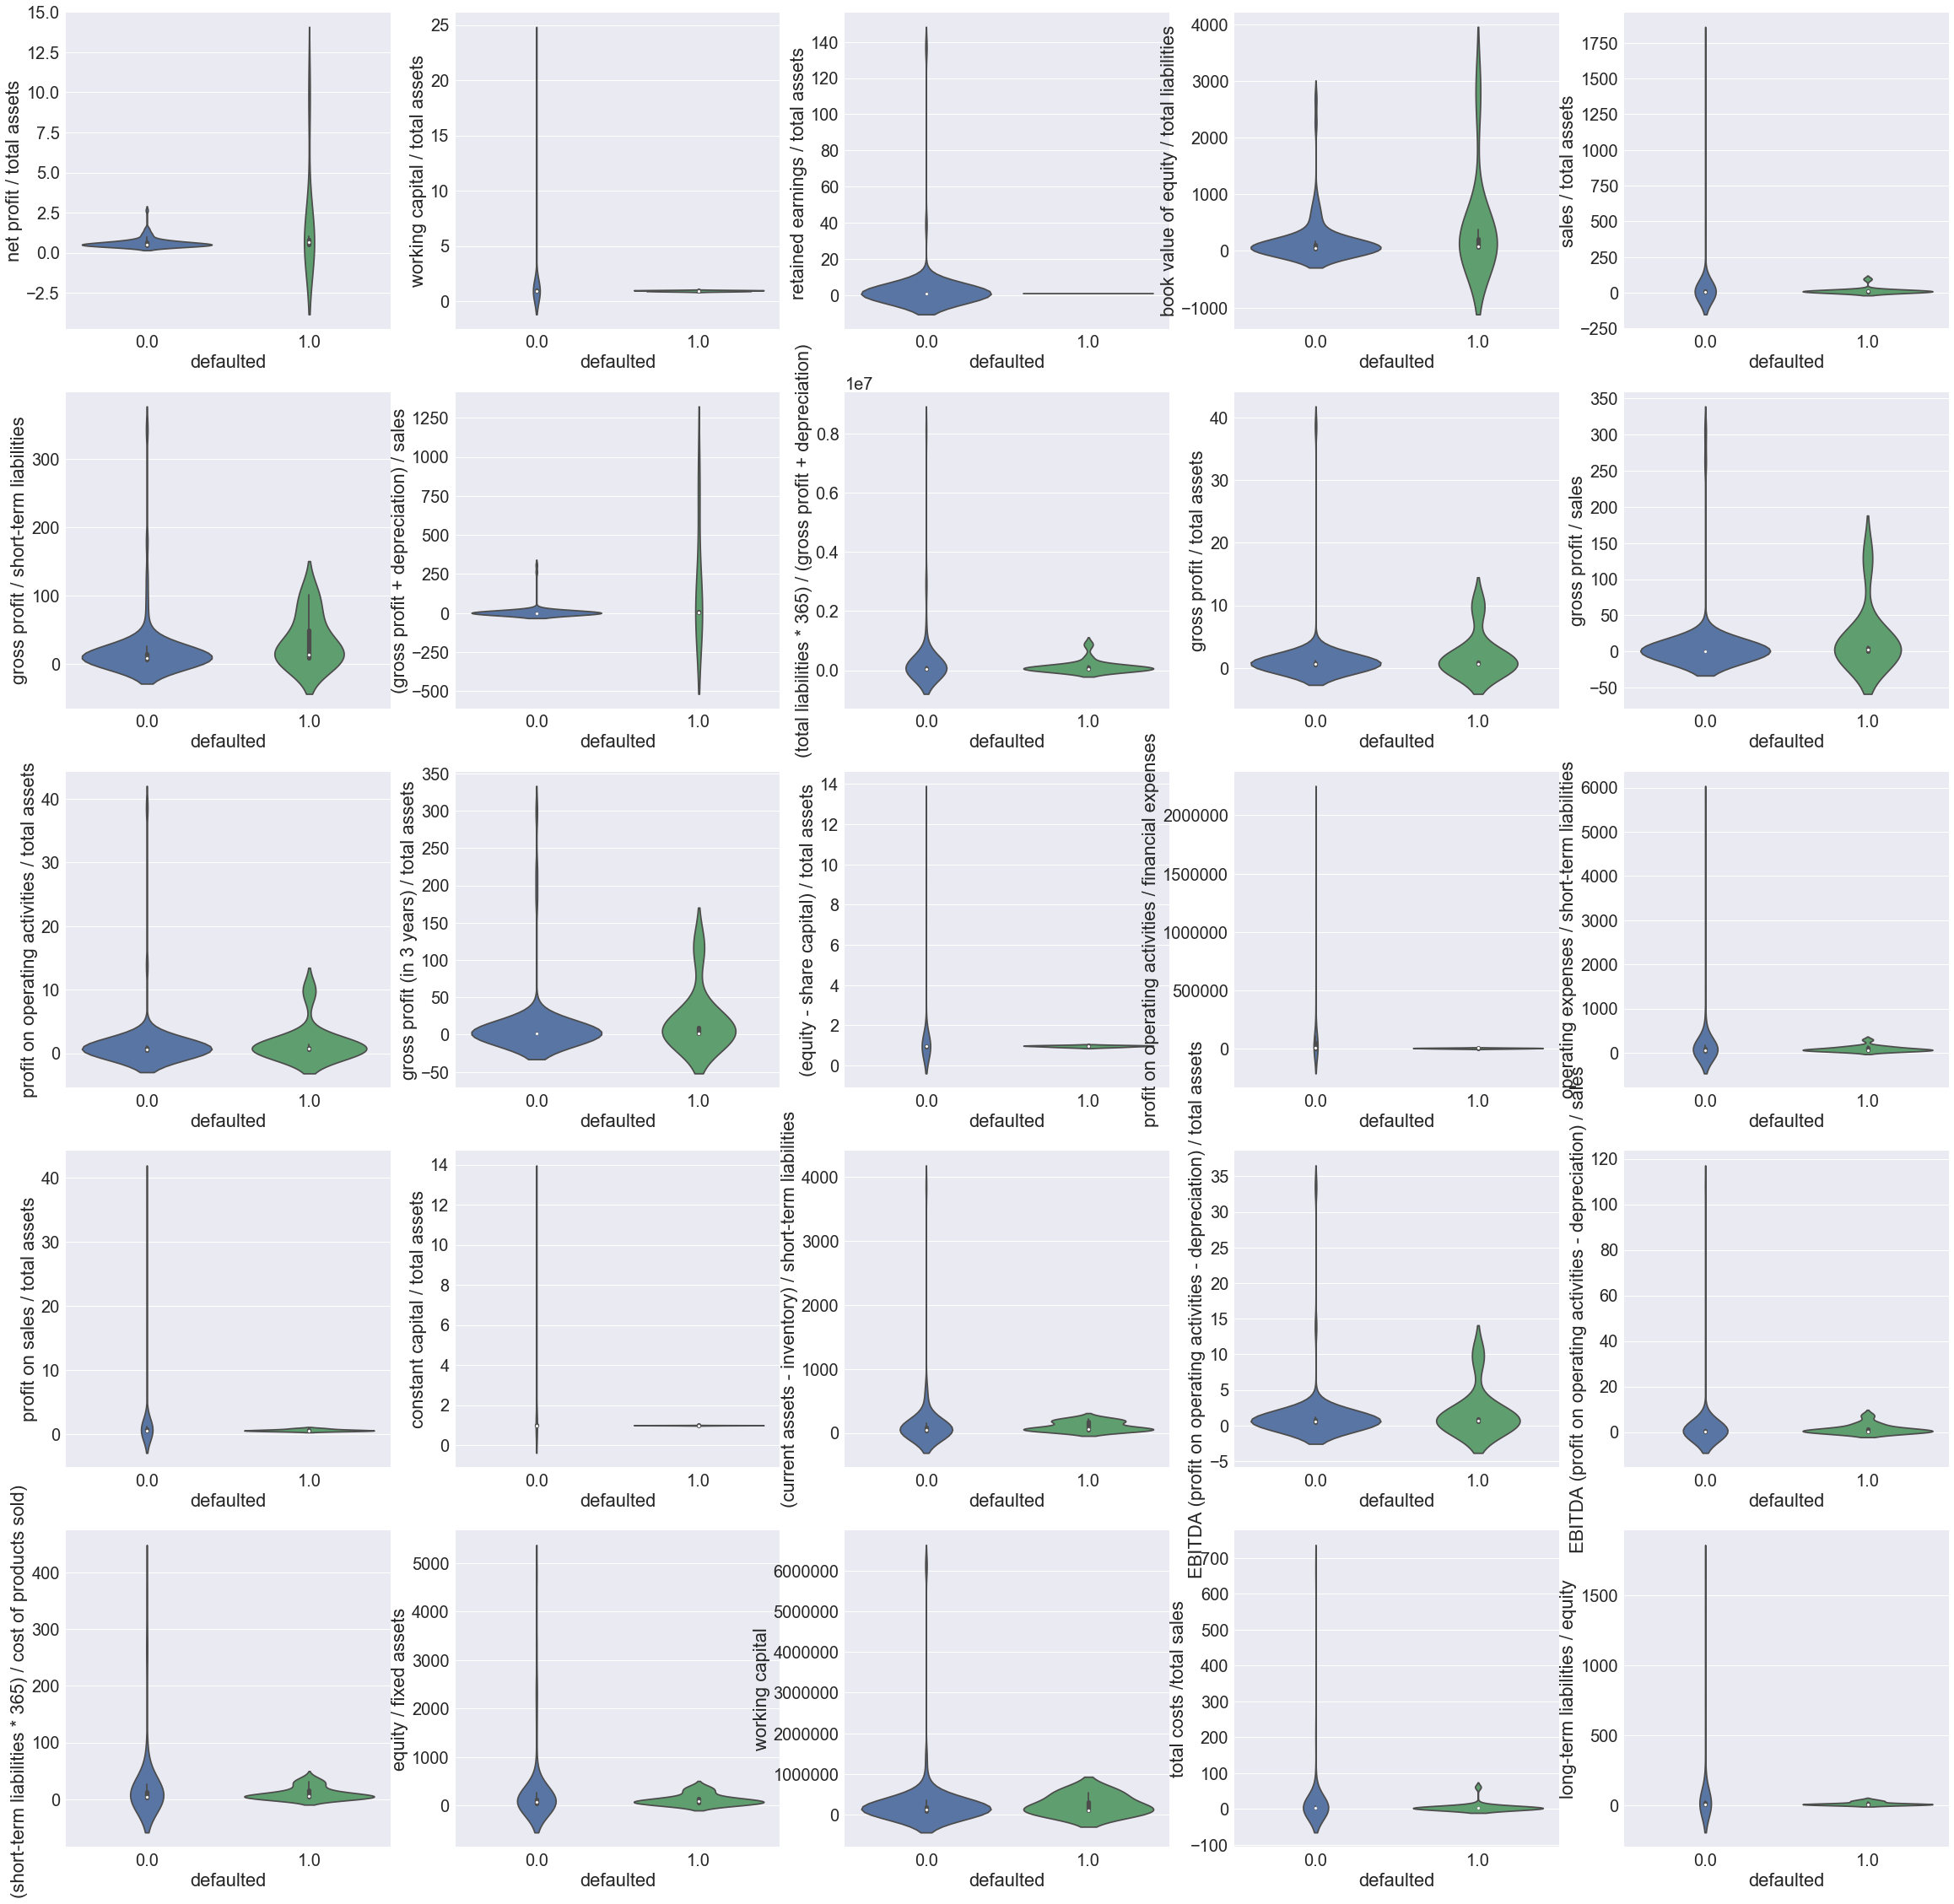

In [20]:
plt.figure(figsize=(40,40))
for i in range(len(features)):
    plt.subplot(5,5,i+1)
    ax = sns.violinplot(x='defaulted', y=features[i], data=data.where(data[features[i]] > data[features[i]].quantile(0.98)))



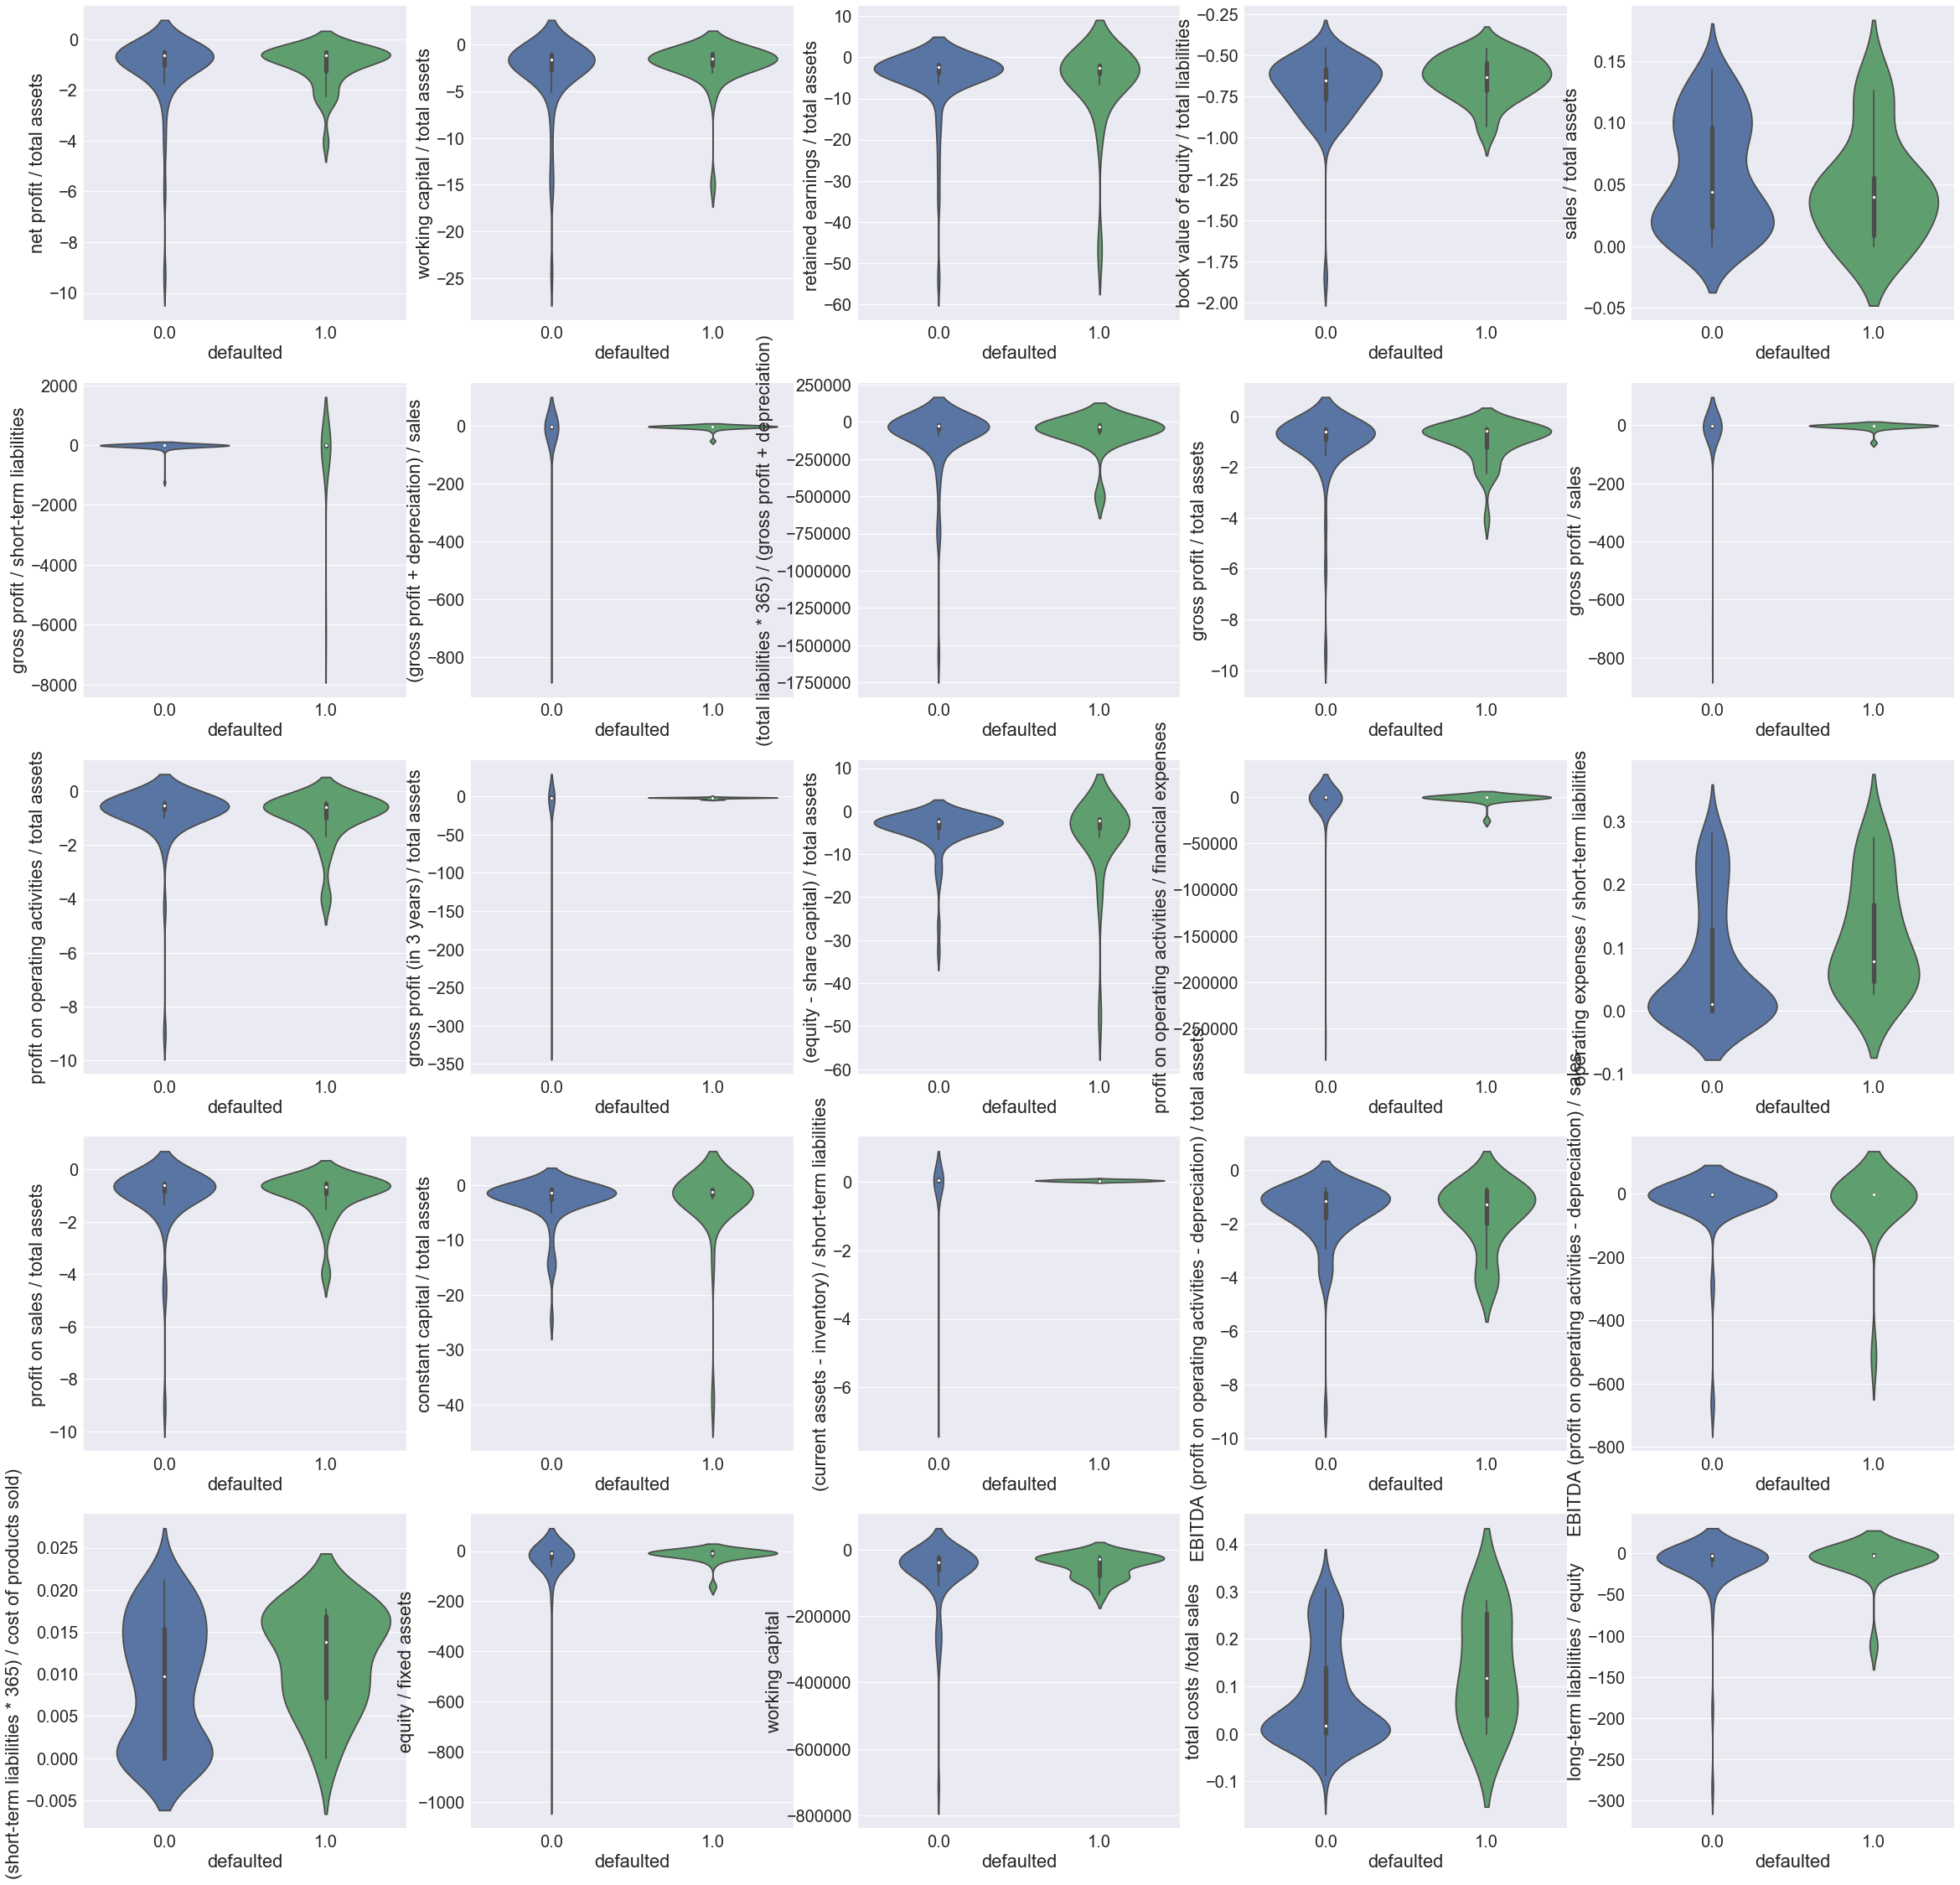

In [21]:
plt.figure(figsize=(40,40))
for i in range(len(features)):
    plt.subplot(5,5,i+1)
    ax = sns.violinplot(x='defaulted', y=features[i], data=data.where(data[features[i]] < data[features[i]].quantile(0.02)))




### Naive Bayes


In [81]:
from sklearn.naive_bayes import GaussianNB
clf = GaussianNB()
scores = cross_val_score(clf,data[selected_features], data['defaulted'],cv=5, scoring = 'f1')
print(scores.mean(), scores.std())

0.1802677563942079 0.003838736284175027


### Results after emoving the 'outlier'

In [88]:
X_train, X_test, y_train, y_test = train_test_split(data_rm[selected_features], data_rm['defaulted'],random_state=10)
clf = RandomForestClassifier()
param_grid = {'n_estimators': [50, 300, 500], 'max_depth' : [6,7,8,9,10]}
CV_rfc = GridSearchCV(estimator=clf, param_grid=param_grid, cv=5,scoring='f1')
CV_rfc.fit(X_train, y_train)
print(CV_rfc.best_params_)
print(CV_rfc.best_score_)

clf_optimized = RandomForestClassifier(n_estimators = CV_rfc.best_params_['n_estimators'],max_depth= CV_rfc.best_params_['max_depth'])
for cutoff in np.arange(0.1,0.9,0.1):
    scores = cross_val_score(clf_optimized,data_rm[selected_features], data_rm['defaulted'],cv=5, scoring = custom_f1(cutoff))
    print('cutoff:', cutoff, 'Self-defined cutoff f1_score:', scores.mean(), scores.std())
    

    


{'max_depth': 10, 'n_estimators': 50}
0.3932036670950916
cutoff: 0.1 Self-defined cutoff f1_score: 0.39003569888718503 0.013725549410424864
cutoff: 0.2 Self-defined cutoff f1_score: 0.4765838737256913 0.0203399229152574
cutoff: 0.30000000000000004 Self-defined cutoff f1_score: 0.4893531113516742 0.018083746962144914
cutoff: 0.4 Self-defined cutoff f1_score: 0.43966837958204863 0.058135763284063766
cutoff: 0.5 Self-defined cutoff f1_score: 0.387850536982558 0.04820452473906496
cutoff: 0.6 Self-defined cutoff f1_score: 0.3346316922182361 0.04763048255841533
cutoff: 0.7000000000000001 Self-defined cutoff f1_score: 0.2557143366907447 0.045352128302911736
cutoff: 0.8 Self-defined cutoff f1_score: 0.20049042626824837 0.03245263439099733


Removing outliers didn't improve the results

### Binning data

In [89]:
selected_features

Index(['profit on operating activities / financial expenses',
       '(current assets - inventory) / short-term liabilities',
       'gross profit (in 3 years) / total assets',
       'profit on sales / total assets', 'total costs /total sales',
       '(total liabilities * 365) / (gross profit + depreciation)',
       'retained earnings / total assets ',
       '(gross profit + depreciation) / sales',
       'constant capital / total assets',
       '(equity - share capital) / total assets'],
      dtype='object')

In [239]:
data_new = pd.DataFrame()
binnum = 10
for i in range(len(selected_features)):
    col_name = i
    data_new[col_name] = pd.qcut(data[selected_features[i]],binnum,duplicates='drop')
data_new['defaulted'] = data['defaulted']

In [240]:
data_new.head()

0                            1                2  \
0  (2.346, 5.638]               (0.317, 0.506]   (0.145, 0.223]   
1   (-2.303, 0.0]                (0.674, 0.84]   (0.145, 0.223]   
2  (0.188, 0.648]                (0.84, 1.035]  (0.0806, 0.145]   
3  (1.265, 2.346]               (0.506, 0.674]     (0.223, 0.3]   
4  (1.265, 2.346]  (-6.640000000000001, 0.317]  (0.0806, 0.145]   

                  3                 4                    5                  6  \
0  (0.0448, 0.0697]     (0.938, 0.96]   (1342.04, 2041.71]      (-0.039, 0.0]   
1  (0.0234, 0.0448]  (-0.0873, 0.756]   (554.918, 888.815]      (-0.039, 0.0]   
2  (0.0234, 0.0448]    (0.976, 0.991]   (888.815, 1342.04]    (0.0132, 0.116]   
3   (0.0697, 0.103]    (0.976, 0.991]  (5515.3, 8090000.0]  (-53.803, -0.248]   
4   (0.0697, 0.103]     (0.96, 0.976]    (2041.71, 3070.8]      (-0.039, 0.0]   

                   7                 8                  9  defaulted  
0     (0.107, 0.144]    (0.538, 0.604]      (0.37, 0.469]          0  
1     (0.144, 0.217]     (0.35, 0.459]      (0.37, 0.469]          0  
2    (0.0605, 0.081]    (0.604, 0.668]      (0.556, 0.66]          0  
3  (0.00677, 0.0257]  (-39.157, 0.188]  (-47.532, -0.103]          0  
4     (0.081, 0.107]    (0.459, 0.538]     (0.178, 0.273]          0

In [241]:
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
label = LabelEncoder()
for i in range(len(selected_features)):
    data_new[i]=label.fit_transform(data_new[i])



In [242]:
data_new

0  1  2  3  4  5  6  7  8  9  defaulted
0     6  1  5  5  4  6  2  7  4  5          0
1     1  3  5  4  0  4  2  8  2  5          0
2     3  4  4  4  6  5  4  5  5  7          0
3     5  2  6  6  6  9  0  2  0  0          0
4     5  0  4  6  5  7  2  6  3  3          0
5     3  5  7  5  6  4  6  4  3  6          0
6     9  5  4  7  9  2  0  9  0  2          0
7     0  9  0  6  9  1  0  0  9  0          0
8     8  8  6  5  2  2  2  9  9  6          0
9     8  6  6  7  5  7  2  3  1  3          0
10    4  9  4  4  6  8  0  5  7  0          0
11    8  9  9  9  0  2  2  9  8  8          0
12    3  4  0  6  5  6  0  4  4  5          0
13    5  2  0  0  7  9  0  3  1  0          0
14    1  3  0  0  9  1  0  0  3  0          0
15    5  5  7  4  6  9  2  1  5  4          0
16    7  5  6  6  4  7  2  5  2  3          0
17    1  9  6  2  0  1  2  9  9  9          0
18    6  4  6  2  7  7  2  3  3  5          0
19    2  5  4  3  7  9  4  1  1  4          0
20    2  0  1  3  7  9  1  3  2  1          0
21    1  3  6  3  4  8  0  3  0  0          0
22    3  5  5  4  5  6  5  6  5  7          0
23    5  6  3  8  1  4  4  8  3  6          0
24    8  9  3  5  1  2  2  9  9  9          0
25    7  7  6  7  1  5  6  7  7  7          0
26    1  8  4  2  4  6  2  4  8  7          0
27    1  1  0  5  2  0  0  0  1  0          0
28    6  5  6  8  4  5  4  5  4  6          0
29    6  3  6  6  5  7  2  4  2  5          0
...  .. .. .. .. .. .. .. .. .. ..        ...
4970  6  0  0  9  0  9  0  8  0  0          1
4971  9  0  0  0  8  1  0  0  0  1          1
4972  9  3  2  3  7  7  4  3  3  6          1
4973  0  2  1  0  9  0  2  1  2  3          1
4974  1  0  0  2  8  0  0  1  0  0          1
4975  9  9  1  1  9  0  2  0  9  3          1
4976  9  1  2  4  7  8  3  2  1  2          1
4977  9  5  0  0  9  1  0  0  0  2          1
4978  4  6  7  8  0  5  2  7  1  3          1
4979  4  1  4  1  6  9  2  1  1  3          1
4980  9  1  6  8  6  5  5  5  1  3          1
4981  3  0  1  3  6  0  1  0  0  0          1
4982  9  2  3  4  7  8  4  4  2  2          1
4983  6  6  6  4  7  9  2  1  4  7          1
4984  4  0  1  3  5  9  2  4  2  1          1
4985  0  3  1  1  7  9  0  3  3  1          1
4986  2  0  2  4  5  9  2  3  4  1          1
4987  9  1  3  4  6  6  4  5  2  4          1
4988  9  1  2  2  8  9  2  2  2  4          1
4989  0  2  0  0  9  1  0  0  0  0          1
4990  0  0  1  1  8  0  0  1  0  0          1
4991  9  0  0  0  9  0  0  0  0  0          1
4992  7  3  7  9  1  5  2  7  1  2          1
4993  5  2  2  6  5  7  2  4  5  2          1
4994  0  0  1  1  8  1  2  1  2  0          1
4995  6  4  9  3  7  6  2  4  4  6          1
4996  0  4  1  1  0  1  2  0  4  0          1
4997  4  0  2  5  5  7  5  5  3  3          1
4998  9  9  0  0  7  1  0  0  9  9          1
4999  7  4  6  7  4  6  2  5  2  2          1

[5000 rows x 11 columns]

In [243]:
X_train, X_test, y_train, y_test = train_test_split(data_new.drop(columns =['defaulted']), 
                                                    data_new['defaulted'])
clf = RandomForestClassifier()     
clf = clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)
f1_score(y_test, y_pred)

0.39999999999999997

### Combining with 'balanced' class_weight

In [244]:
X_train, X_test, y_train, y_test = train_test_split(data_new.drop(columns =['defaulted']), data['defaulted'])
clf=RandomForestClassifier(class_weight = 'balanced')
param_grid = {'n_estimators': [50, 300, 500], 'max_depth' : [6,7,8,9,10]}
CV_rfc = GridSearchCV(estimator=clf, param_grid=param_grid, cv=3,scoring='f1')
CV_rfc.fit(X_train, y_train)
print(CV_rfc.best_params_)
print(CV_rfc.best_score_)

{'max_depth': 9, 'n_estimators': 300}
0.4649783118163868


In [245]:
clf_optimized = RandomForestClassifier(max_depth = CV_rfc.best_params_['max_depth'], 
                                n_estimators =CV_rfc.best_params_['n_estimators'],class_weight = 'balanced' )

In [246]:
scores = cross_val_score(clf_optimized, data_new.drop(columns =['defaulted']), data['defaulted'],
                         scoring='f1', cv=5)
print('f1 score:', scores.mean(), scores.std())
scores = cross_val_score(clf_optimized, data_new.drop(columns =['defaulted']), data['defaulted'],
                         scoring='roc_auc', cv=5)
print('roc_auc score:', scores.mean(), scores.std())

f1 score: 0.47163016710851585 0.03173005204410712
roc_auc score: 0.8600644444444445 0.007251776793770371


f1 score gets increased to **0.47(3)** through binning and balanced class weight

### Combining with self-defined cutoff

In [187]:
X_train, X_test, y_train, y_test = train_test_split(data_new.drop(columns =['defaulted']), data['defaulted'])
clf = RandomForestClassifier()
param_grid = {'n_estimators': [50, 300, 500], 'max_depth' : [6,7,8,9,10]}
CV_rfc = GridSearchCV(estimator=clf, param_grid=param_grid, cv=3,scoring='f1')
CV_rfc.fit(X_train, y_train)
print(CV_rfc.best_params_)
print(CV_rfc.best_score_)




{'max_depth': 10, 'n_estimators': 500}
0.4332410795259093


In [186]:
clf_optimized = RandomForestClassifier(n_estimators = CV_rfc.best_params_['n_estimators'],max_depth= CV_rfc.best_params_['max_depth'])
for cutoff in np.arange(0.1,0.9,0.1):
    scores = cross_val_score(clf_optimized, data_new.drop(columns =['defaulted']), data['defaulted'],cv=5, scoring = custom_f1(cutoff))
    print('cutoff:', cutoff, 'Self-defined cutoff f1_score:', scores.mean(), scores.std())
    

    

cutoff: 0.1 Self-defined cutoff f1_score: 0.3920232055888914 0.02149155703925679
cutoff: 0.2 Self-defined cutoff f1_score: 0.48128338455346065 0.028166106962565867
cutoff: 0.30000000000000004 Self-defined cutoff f1_score: 0.5132304905711829 0.042334081246360386
cutoff: 0.4 Self-defined cutoff f1_score: 0.48575483397848396 0.046267132576189404
cutoff: 0.5 Self-defined cutoff f1_score: 0.41021265969707416 0.040037870859999374
cutoff: 0.6 Self-defined cutoff f1_score: 0.34072957036700996 0.05545070338538201
cutoff: 0.7000000000000001 Self-defined cutoff f1_score: 0.2835923653416435 0.04021301507153538
cutoff: 0.8 Self-defined cutoff f1_score: 0.1949317556241688 0.046648137022956414


### Trying with equal binwidth, together with quantile cut

Not much improvement

In [218]:

for i in range(len(selected_features)):
    col_name = i+len(selected_features)
    data_new[col_name] = pd.cut(data[selected_features[i]],10)
data_new['defaulted'] = data['defaulted']

In [219]:
data_new.head()

0  1  2  3  4  5  6  7  8  9  defaulted                    10  \
0  6  1  5  5  4  6  2  7  4  5          0  (-29100.0, 200800.0]   
1  1  3  5  4  0  4  2  8  2  5          0  (-29100.0, 200800.0]   
2  3  4  4  4  6  5  4  5  5  7          0  (-29100.0, 200800.0]   
3  5  2  6  6  6  9  0  2  0  0          0  (-29100.0, 200800.0]   
4  5  0  4  6  5  7  2  6  3  3          0  (-29100.0, 200800.0]   

                   11               12               13                14  \
0  (-10.494, 378.855]  (-7.595, 53.76]  (-4.277, 0.489]  (-0.755, 66.797]   
1  (-10.494, 378.855]  (-7.595, 53.76]  (-4.277, 0.489]  (-0.755, 66.797]   
2  (-10.494, 378.855]  (-7.595, 53.76]  (-4.277, 0.489]  (-0.755, 66.797]   
3  (-10.494, 378.855]  (-7.595, 53.76]  (-4.277, 0.489]  (-0.755, 66.797]   
4  (-10.494, 378.855]  (-7.595, 53.76]  (-4.277, 0.489]  (-0.755, 66.797]   

                      15                16                 17              18  \
0  (-604000.0, 362000.0]  (-15.632, 3.454]  (-151.106, 8.145]  (-2.925, 2.25]   
1  (-604000.0, 362000.0]  (-15.632, 3.454]  (-151.106, 8.145]  (-2.925, 2.25]   
2  (-604000.0, 362000.0]  (-15.632, 3.454]  (-151.106, 8.145]  (-2.925, 2.25]   
3  (-604000.0, 362000.0]  (-15.632, 3.454]  (-151.106, 8.145]  (-2.925, 2.25]   
4  (-604000.0, 362000.0]  (-15.632, 3.454]  (-151.106, 8.145]  (-2.925, 2.25]   

                19  
0  (-5.438, 0.575]  
1  (-5.438, 0.575]  
2   (0.575, 6.589]  
3  (-5.438, 0.575]  
4  (-5.438, 0.575]

In [220]:
label = LabelEncoder()
for i in range(10):
    data_new[i+len(selected_features)]=label.fit_transform(data_new[i+len(selected_features)])

data_new.head()

0  1  2  3  4  5  6  7  8  9  defaulted  10  11  12  13  14  15  16  17  \
0  6  1  5  5  4  6  2  7  4  5          0   1   0   1   1   0   1   2   1   
1  1  3  5  4  0  4  2  8  2  5          0   1   0   1   1   0   1   2   1   
2  3  4  4  4  6  5  4  5  5  7          0   1   0   1   1   0   1   2   1   
3  5  2  6  6  6  9  0  2  0  0          0   1   0   1   1   0   1   2   1   
4  5  0  4  6  5  7  2  6  3  3          0   1   0   1   1   0   1   2   1   

   18  19  
0   5   6  
1   5   6  
2   5   7  
3   5   6  
4   5   6

In [221]:
X_train, X_test, y_train, y_test = train_test_split(data_new.drop(columns =['defaulted']), data['defaulted'])
clf=RandomForestClassifier(class_weight = 'balanced')
param_grid = {'n_estimators': [50, 300, 500], 'max_depth' : [6,7,8,9,10]}
CV_rfc = GridSearchCV(estimator=clf, param_grid=param_grid, cv=3,scoring='f1')
CV_rfc.fit(X_train, y_train)
print(CV_rfc.best_params_)
print(CV_rfc.best_score_)

{'max_depth': 9, 'n_estimators': 500}
0.4510510489611877


In [222]:
clf_optimized = RandomForestClassifier(max_depth = CV_rfc.best_params_['max_depth'], 
                                n_estimators =CV_rfc.best_params_['n_estimators'],class_weight = 'balanced' )

In [223]:
scores = cross_val_score(clf_optimized, data_new.drop(columns =['defaulted']), data['defaulted'],
                         scoring='f1', cv=5)
print('f1 score:', scores.mean(), scores.std())
scores = cross_val_score(clf_optimized, data_new.drop(columns =['defaulted']), data['defaulted'],
                         scoring='roc_auc', cv=5)
print('roc_auc score:', scores.mean(), scores.std())

f1 score: 0.45628433005618446 0.032294547567507874
roc_auc score: 0.8512366666666666 0.008115329648796864
